In [54]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))

from heatflux_functions import * 

from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.casedeck import*
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *
from hermes3.selectors import *

# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:


def replace_guards(var):
    """
	This in-place replaces the points in the guard cells with the points on the boundary
    
    """
    # Strip the edge guard cells
    var = var[1:-1]

    var[0] = 0.5*(var[0] + var[1])
    var[-1] = 0.5*(var[-1] + var[-2])
    return var

In [56]:
import scipy.integrate

def divq_integrate(dataframe, snb_int = False):
    """
    Calculate the total heat flux from the divergence of the Spitzer-Harm fluxes.
    If snb == True outputs integral of divq_snb, otherwise outputs integral of divq_sh.
    """

    x = np.ravel(dataframe['y'].values)[1:-1]
    Te = np.ravel(dataframe['Te'].values)


    div_q_snb = replace_guards(np.ravel(dataframe['Div_Q_SNB'].values))
    div_q_sh = replace_guards(np.ravel(dataframe['Div_Q_SH'].values))

    print('x =' , len(x))
    print('div_q_snb = ' , len(div_q_snb))

    q_snb = scipy.integrate.cumulative_trapezoid(div_q_snb, x, initial=0)
    q_sh = scipy.integrate.cumulative_trapezoid(div_q_sh, x, initial=0)

    if snb_int == False:
        return q_sh
    else:
        return q_snb

In [57]:
def spitzer_q(dataframe):
    
    x = dataframe['y']
    Te = dataframe['Te']
    Ti = dataframe['Td+']
    Ne = dataframe['Ne']
    Ni = dataframe['Nd+']
    kappa_e = dataframe['kappa_par_e']
    kappa_i = dataframe['kappa_par_d+']

    # print(kappa_e)

    grad_T = np.gradient(Te, x)
    q = -kappa_e * grad_T

    return q

# I/O

In [58]:

alpha_vals = [-1, 0.2, 0.06, 'snb']
neon_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
parent_dir = '/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2024-03-25_wigram_reference_glover_comparison_FINAL_restart_selective_collisions'


cs = dict()


for alpha in alpha_vals:
    for neon in neon_vals:
        name = f"alpha_{alpha}_neon_{neon}"
        print(f"Loading {name}")
        cs[name] = Load.case_1D(f'{parent_dir}/alpha_{alpha}/neon_{neon}', guard_replace = False, use_squash=True)


Loading alpha_-1_neon_0.0
- Looking for squash file
- Squash file found. squash date 03/31/2025, 16:18:21, dmp file date 01/17/2025, 09:02:14
Skipping unnormalisation
Loading alpha_-1_neon_0.01
- Looking for squash file
- Squash file found. squash date 03/31/2025, 16:20:20, dmp file date 01/21/2025, 19:43:25
Skipping unnormalisation
Loading alpha_-1_neon_0.02
- Looking for squash file
- Squash file found. squash date 03/31/2025, 16:21:46, dmp file date 01/21/2025, 19:41:12
Skipping unnormalisation
Loading alpha_-1_neon_0.03
- Looking for squash file
- Squash file found. squash date 03/31/2025, 16:23:22, dmp file date 01/21/2025, 19:33:44
Skipping unnormalisation
Loading alpha_-1_neon_0.04
- Looking for squash file
- Squash file found. squash date 03/31/2025, 16:24:52, dmp file date 01/21/2025, 19:28:06
Skipping unnormalisation
Loading alpha_-1_neon_0.05
- Looking for squash file
- Squash file found. squash date 03/31/2025, 16:26:24, dmp file date 01/18/2025, 16:49:30
Skipping unnormali

In [59]:
print(f"Loaded {len(cs)} cases")
print(f"Cases: {list(cs.keys())}")

# y = cs['alpha_-1_neon_0.0'].ds['y'].values
# print(y)

Loaded 44 cases
Cases: ['alpha_-1_neon_0.0', 'alpha_-1_neon_0.01', 'alpha_-1_neon_0.02', 'alpha_-1_neon_0.03', 'alpha_-1_neon_0.04', 'alpha_-1_neon_0.05', 'alpha_-1_neon_0.06', 'alpha_-1_neon_0.07', 'alpha_-1_neon_0.08', 'alpha_-1_neon_0.09', 'alpha_-1_neon_0.1', 'alpha_0.2_neon_0.0', 'alpha_0.2_neon_0.01', 'alpha_0.2_neon_0.02', 'alpha_0.2_neon_0.03', 'alpha_0.2_neon_0.04', 'alpha_0.2_neon_0.05', 'alpha_0.2_neon_0.06', 'alpha_0.2_neon_0.07', 'alpha_0.2_neon_0.08', 'alpha_0.2_neon_0.09', 'alpha_0.2_neon_0.1', 'alpha_0.06_neon_0.0', 'alpha_0.06_neon_0.01', 'alpha_0.06_neon_0.02', 'alpha_0.06_neon_0.03', 'alpha_0.06_neon_0.04', 'alpha_0.06_neon_0.05', 'alpha_0.06_neon_0.06', 'alpha_0.06_neon_0.07', 'alpha_0.06_neon_0.08', 'alpha_0.06_neon_0.09', 'alpha_0.06_neon_0.1', 'alpha_snb_neon_0.0', 'alpha_snb_neon_0.01', 'alpha_snb_neon_0.02', 'alpha_snb_neon_0.03', 'alpha_snb_neon_0.04', 'alpha_snb_neon_0.05', 'alpha_snb_neon_0.06', 'alpha_snb_neon_0.07', 'alpha_snb_neon_0.08', 'alpha_snb_neon_0

In [60]:
print(cs['alpha_-1_neon_0.0'].ds.data_vars)

Data variables:
    Bxy                            (pos) float64 dask.array<chunksize=(804,), meta=np.ndarray>
    Ed+_iz                         (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    Ed+_rec                        (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    Ed+_sheath                     (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    Ed_target_recycle              (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    Edd+_cx                        (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    Ee_sheath                      (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    EnergyFlow_d+_ylow             (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    EnergyFlow_e_ylow              (t, pos) float64 dask.array<chunksize=(61, 804), meta=np.ndarray>
    Fd+_iz                         (t, pos) float64 dask.array<chunksize=(61, 804

# Four plot of Te, qe_cond, Ne and Nd

In [61]:
params = ['Te', 'q_cond', 'Ne', 'Nd']
# params = ['Te']

ncols = max(round(len(params)/2), 1)
nrows = ncols

print(ncols, nrows)

fig, ax = plt.subplots(nrows, ncols, figsize=(20, 12), dpi=500)

if isinstance(ax, np.ndarray):  # When multiple subplots
    ax = ax.flatten()  # Flatten the 2D array of axes to 1D
else:  # When there is only one subplot
    ax = np.array([ax])  # Make it a 1D array for consistency

y = cs['alpha_-1_neon_0.0'].ds['y'].values[1:-1]
for i in alpha_vals:
    if i == -1:
        linestyle = '--'
        color = 'red'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'

    for j, value in enumerate(params):

        if value == 'q_cond':
            if i == 'snb':
                profile = divq_integrate(cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1), snb_int=True)
            else:
                profile = replace_guards(spitzer_q(cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)))

            ax[j].plot(y[1:-1], profile[1:-1], linestyle=linestyle, color=color, label=f'alpha={i}')
            if np.max(profile) > 1e3:
                # ax[j].set_yscale('log')
                ax[j].set_ylabel(r'$q_{\parallel, e}$ (W/m$^2$)')
                ax[j].set_xlabel('$S_{\parallel}$ (m)')

        else:
            profile = replace_guards(cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].values)
            ax[j].plot(y, profile, linestyle=linestyle, color=color, label=f'alpha={i}')
            if np.max(profile) > 1e3:
                ax[j].set_yscale('log')
            ax[j].set_xlabel('$S_{\parallel}$ (m)')
            units = cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].units
            ax[j].set_ylabel(f'{value} ({units})')
plt.tight_layout()

2 2
x = 802
div_q_snb =  802


# Target temp vs neon

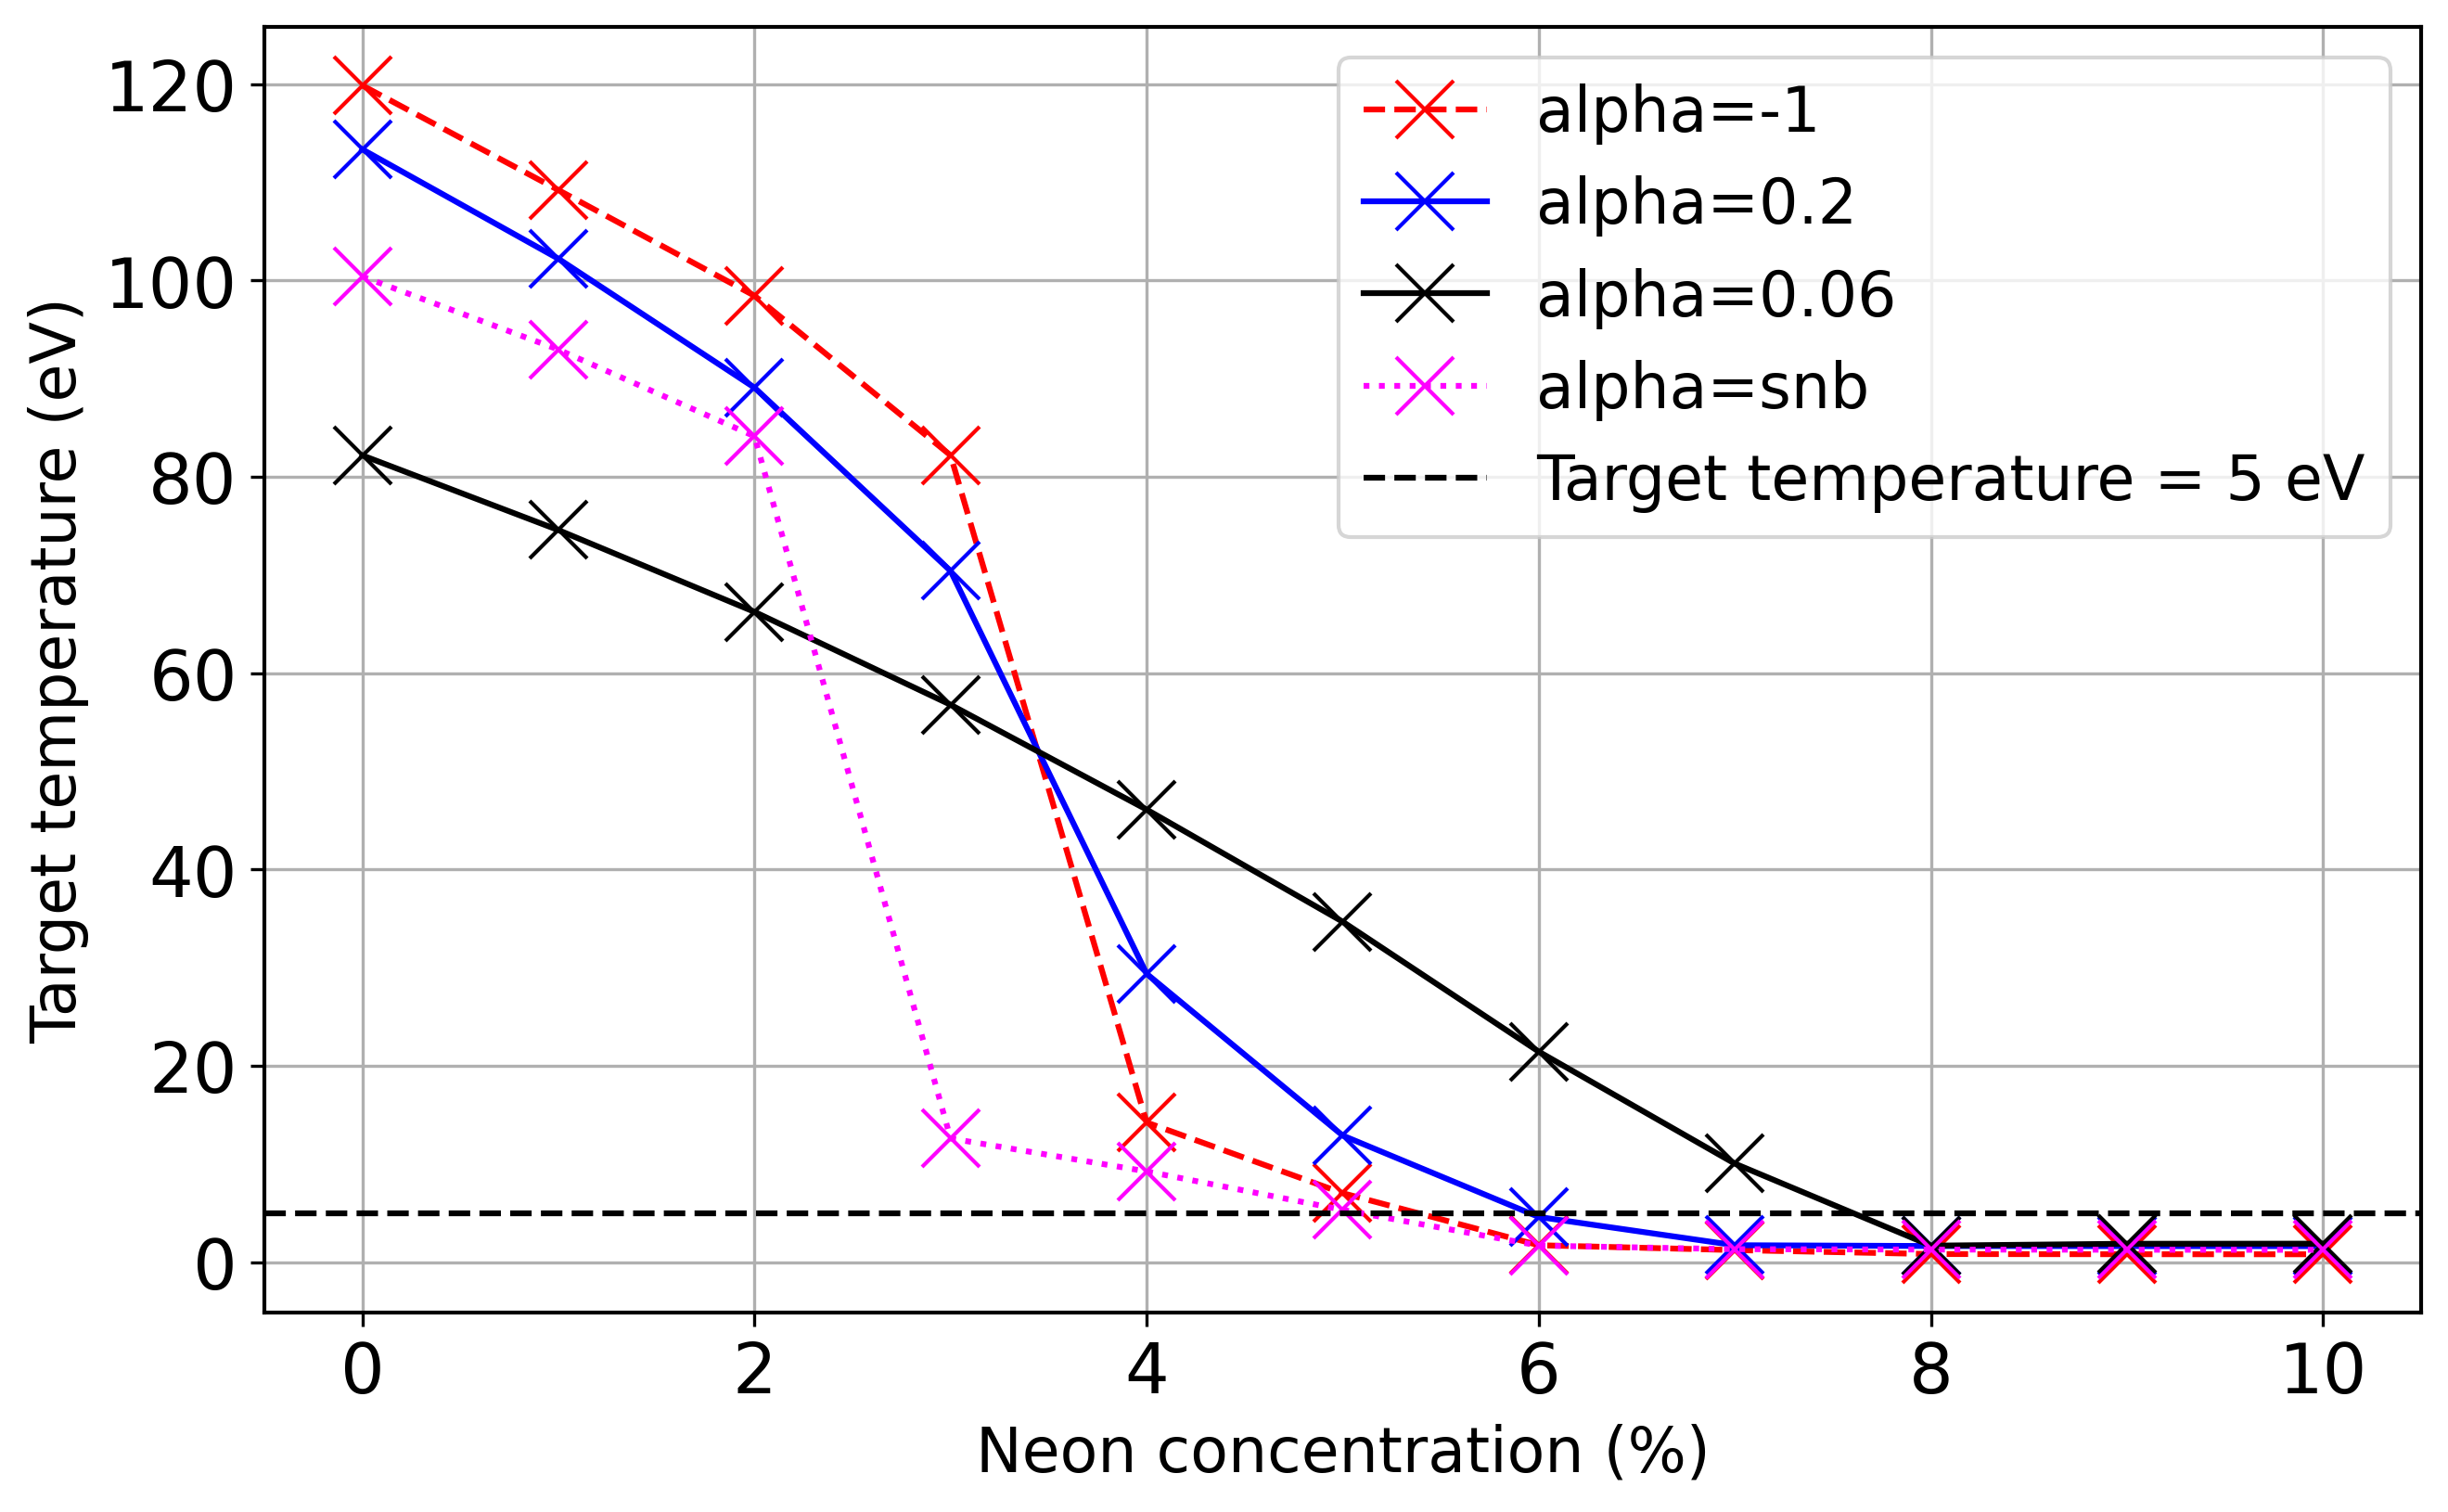

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
# ax2 = ax.twinx()


neon_vals = np.array([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

for i in alpha_vals:
    target_temp_list = []
    neon_radiation_list = []
    if i == -1:
        linestyle = '--'
        color = 'red'
        label = 'SH'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
        label = i
    elif i == 0.06:
        linestyle = '-'
        color = 'black'1
        label = i
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'

    for j in neon_vals:
        target_temp = replace_guards(cs[f'alpha_{i}_neon_{j}'].ds.isel(t=-1)['Te'].values)[-1]
        target_temp_list.append(target_temp)
        neon_radiation = -1 * sum(replace_guards(cs[f'alpha_{i}_neon_{j}'].ds.isel(t=-1)['Rneon'].values) * replace_guards(cs[f'alpha_{i}_neon_{j}'].ds.isel(t=-1)['dv'].values))
        neon_radiation_list.append(neon_radiation)

    ax.plot(np.array(neon_vals)*100, target_temp_list, linestyle=linestyle, color=color, label=f'alpha={label}', markersize=markersize, marker = 'x')
    # ax2.plot(np.array(neon_vals)*100, neon_radiation_list, linestyle=linestyle, color=color, markersize=markersize, marker = 'o')

    
ax.axhline(5, color='black', linestyle='--', label='Target temperature = 5 eV')
ax.set_xlabel('Neon concentration (%)')
ax.set_ylabel('Target temperature (eV)')
ax.legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


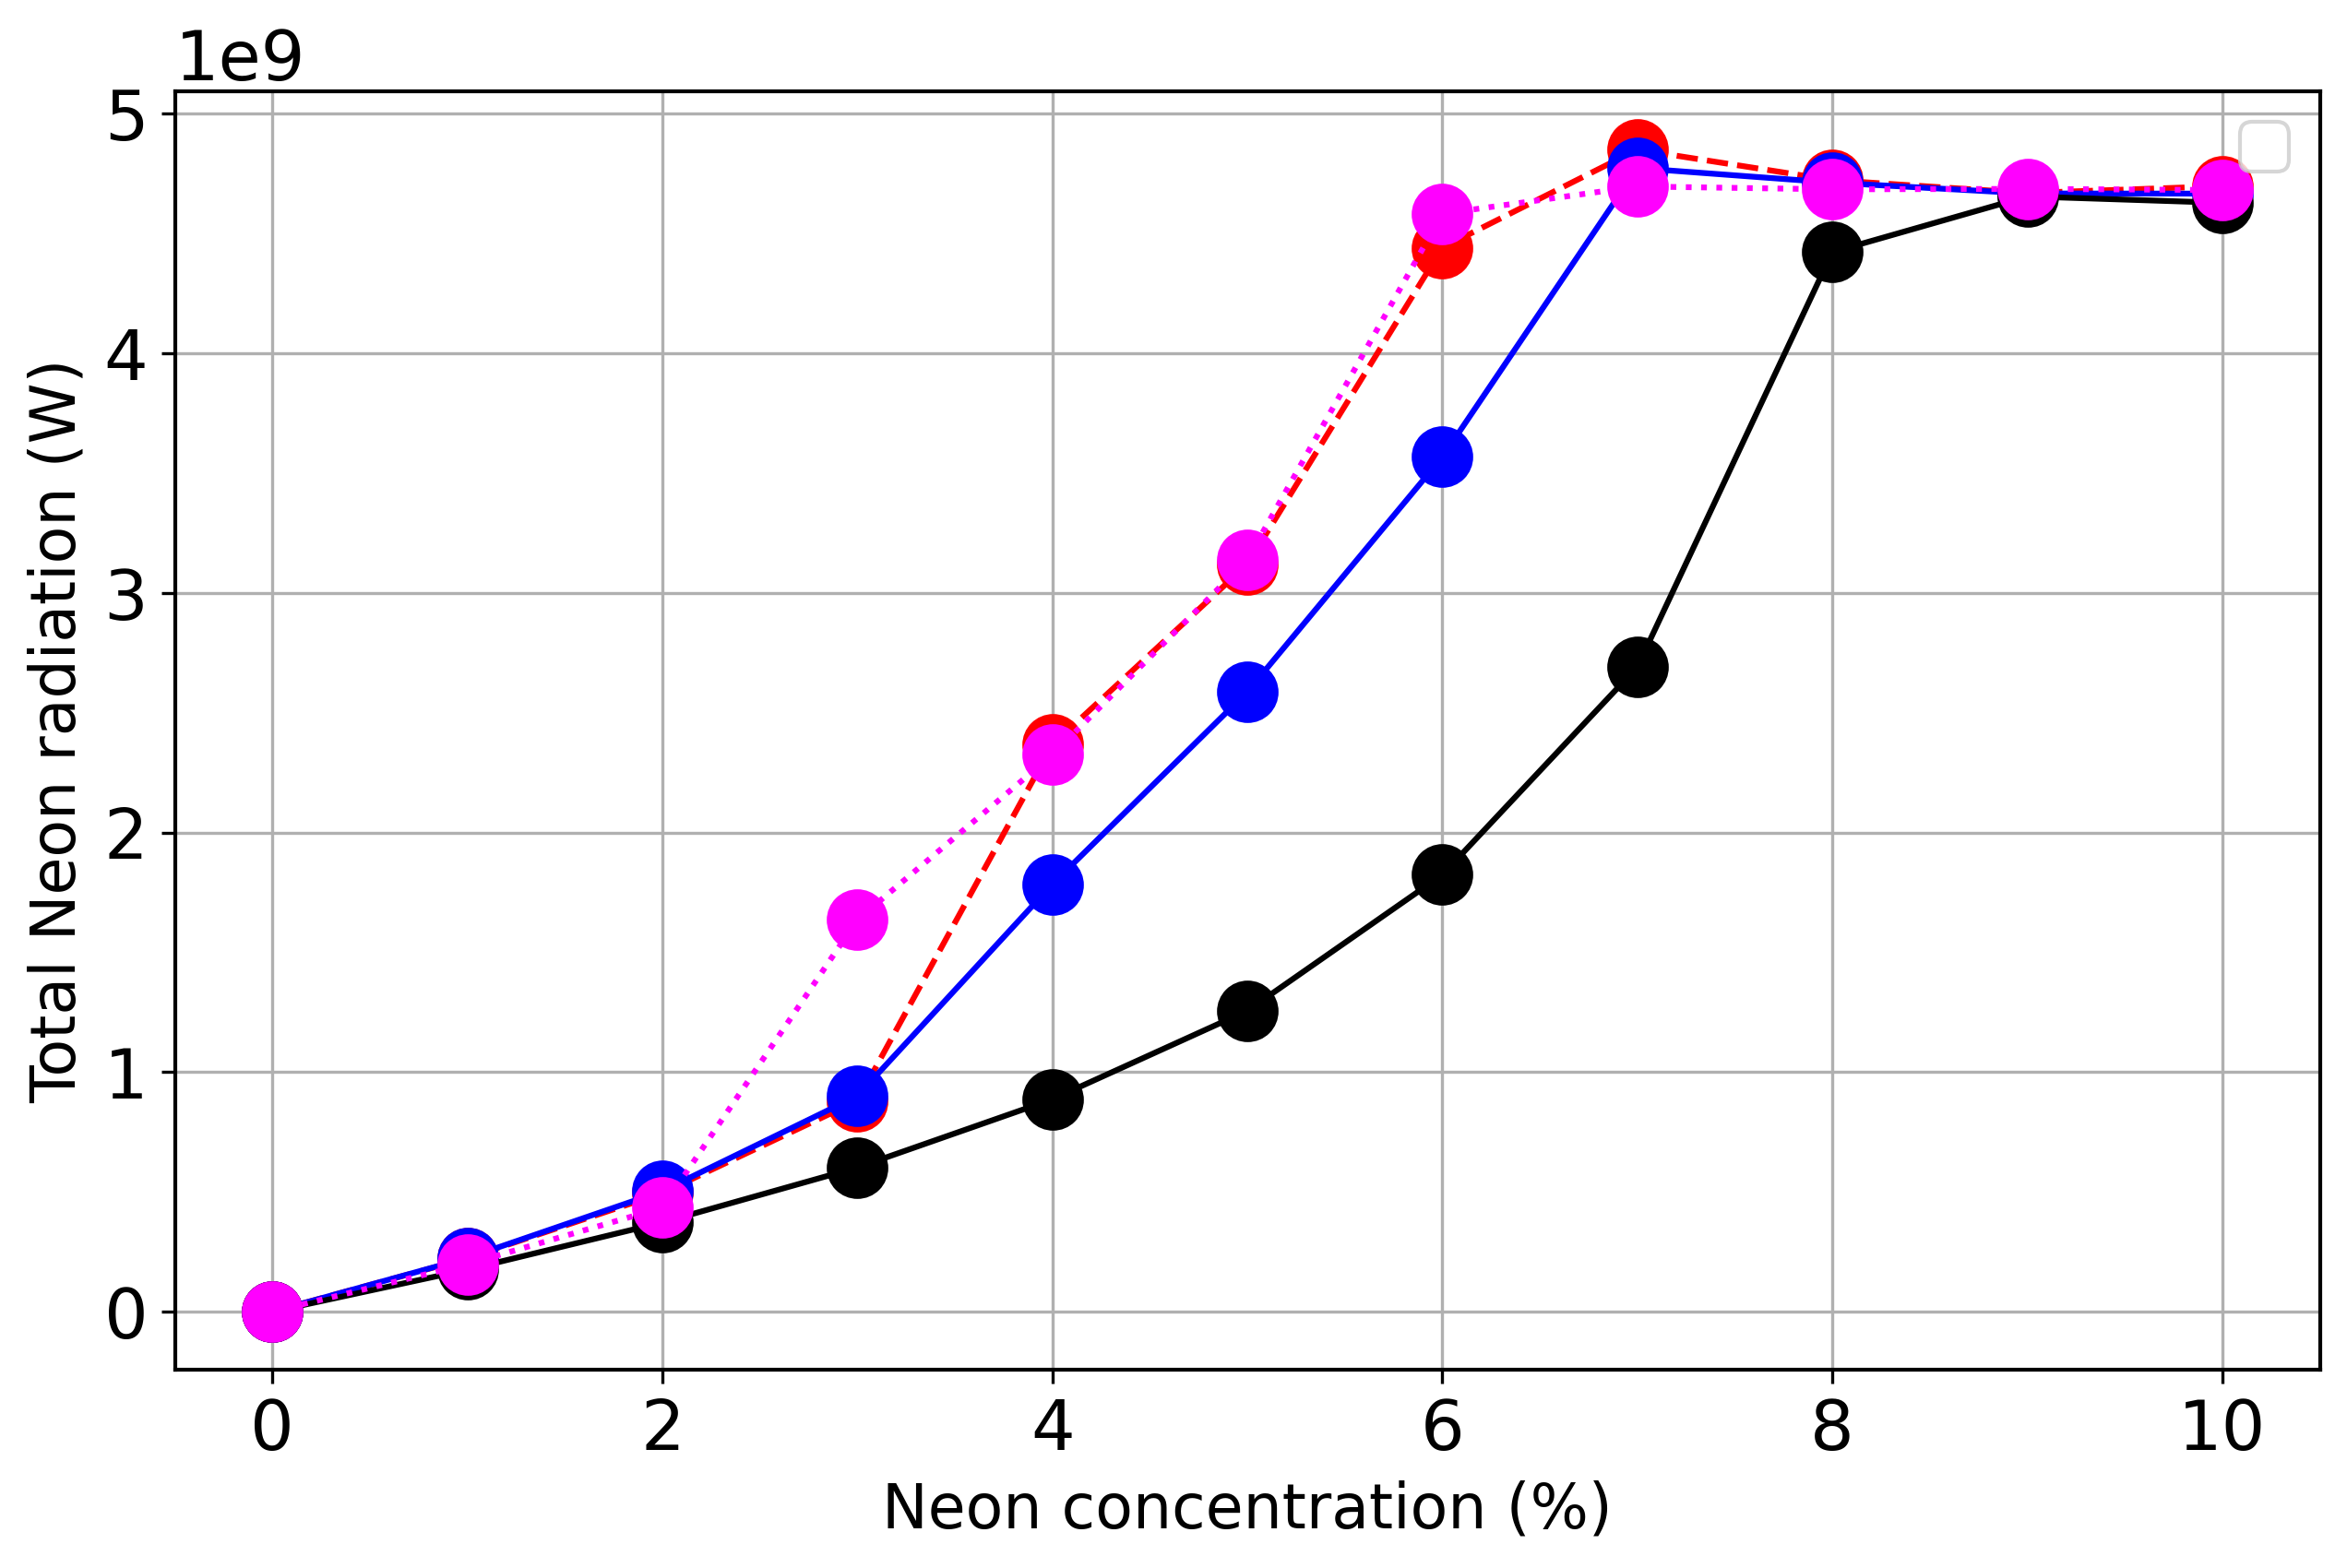

In [83]:
fig,ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
# ax2 = ax.twinx()


neon_vals = np.array([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

for i in alpha_vals:
    target_temp_list = []
    neon_radiation_list = []
    if i == -1:
        linestyle = '--'
        color = 'red'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'

    for j in neon_vals:
        target_temp = replace_guards(cs[f'alpha_{i}_neon_{j}'].ds.isel(t=-1)['Te'].values)[-1]
        target_temp_list.append(target_temp)
        neon_radiation = -1 * sum(replace_guards(cs[f'alpha_{i}_neon_{j}'].ds.isel(t=-1)['Rneon'].values) * replace_guards(cs[f'alpha_{i}_neon_{j}'].ds.isel(t=-1)['dv'].values))
        neon_radiation_list.append(neon_radiation)

    # ax.plot(np.array(neon_vals)*100, target_temp_list, linestyle=linestyle, color=color, label=f'alpha={i}', markersize=markersize, marker = 'x')
    ax.plot(np.array(neon_vals)*100, neon_radiation_list, linestyle=linestyle, color=color, markersize=markersize, marker = 'o')

    
# ax.axhline(5, color='black', linestyle='--', label='Target temperature = 5 eV')
ax.set_xlabel('Neon concentration (%)')
ax.set_ylabel('Total Neon radiation (W)')
ax.legend()

# cmap overlay


88
44.04404404404405


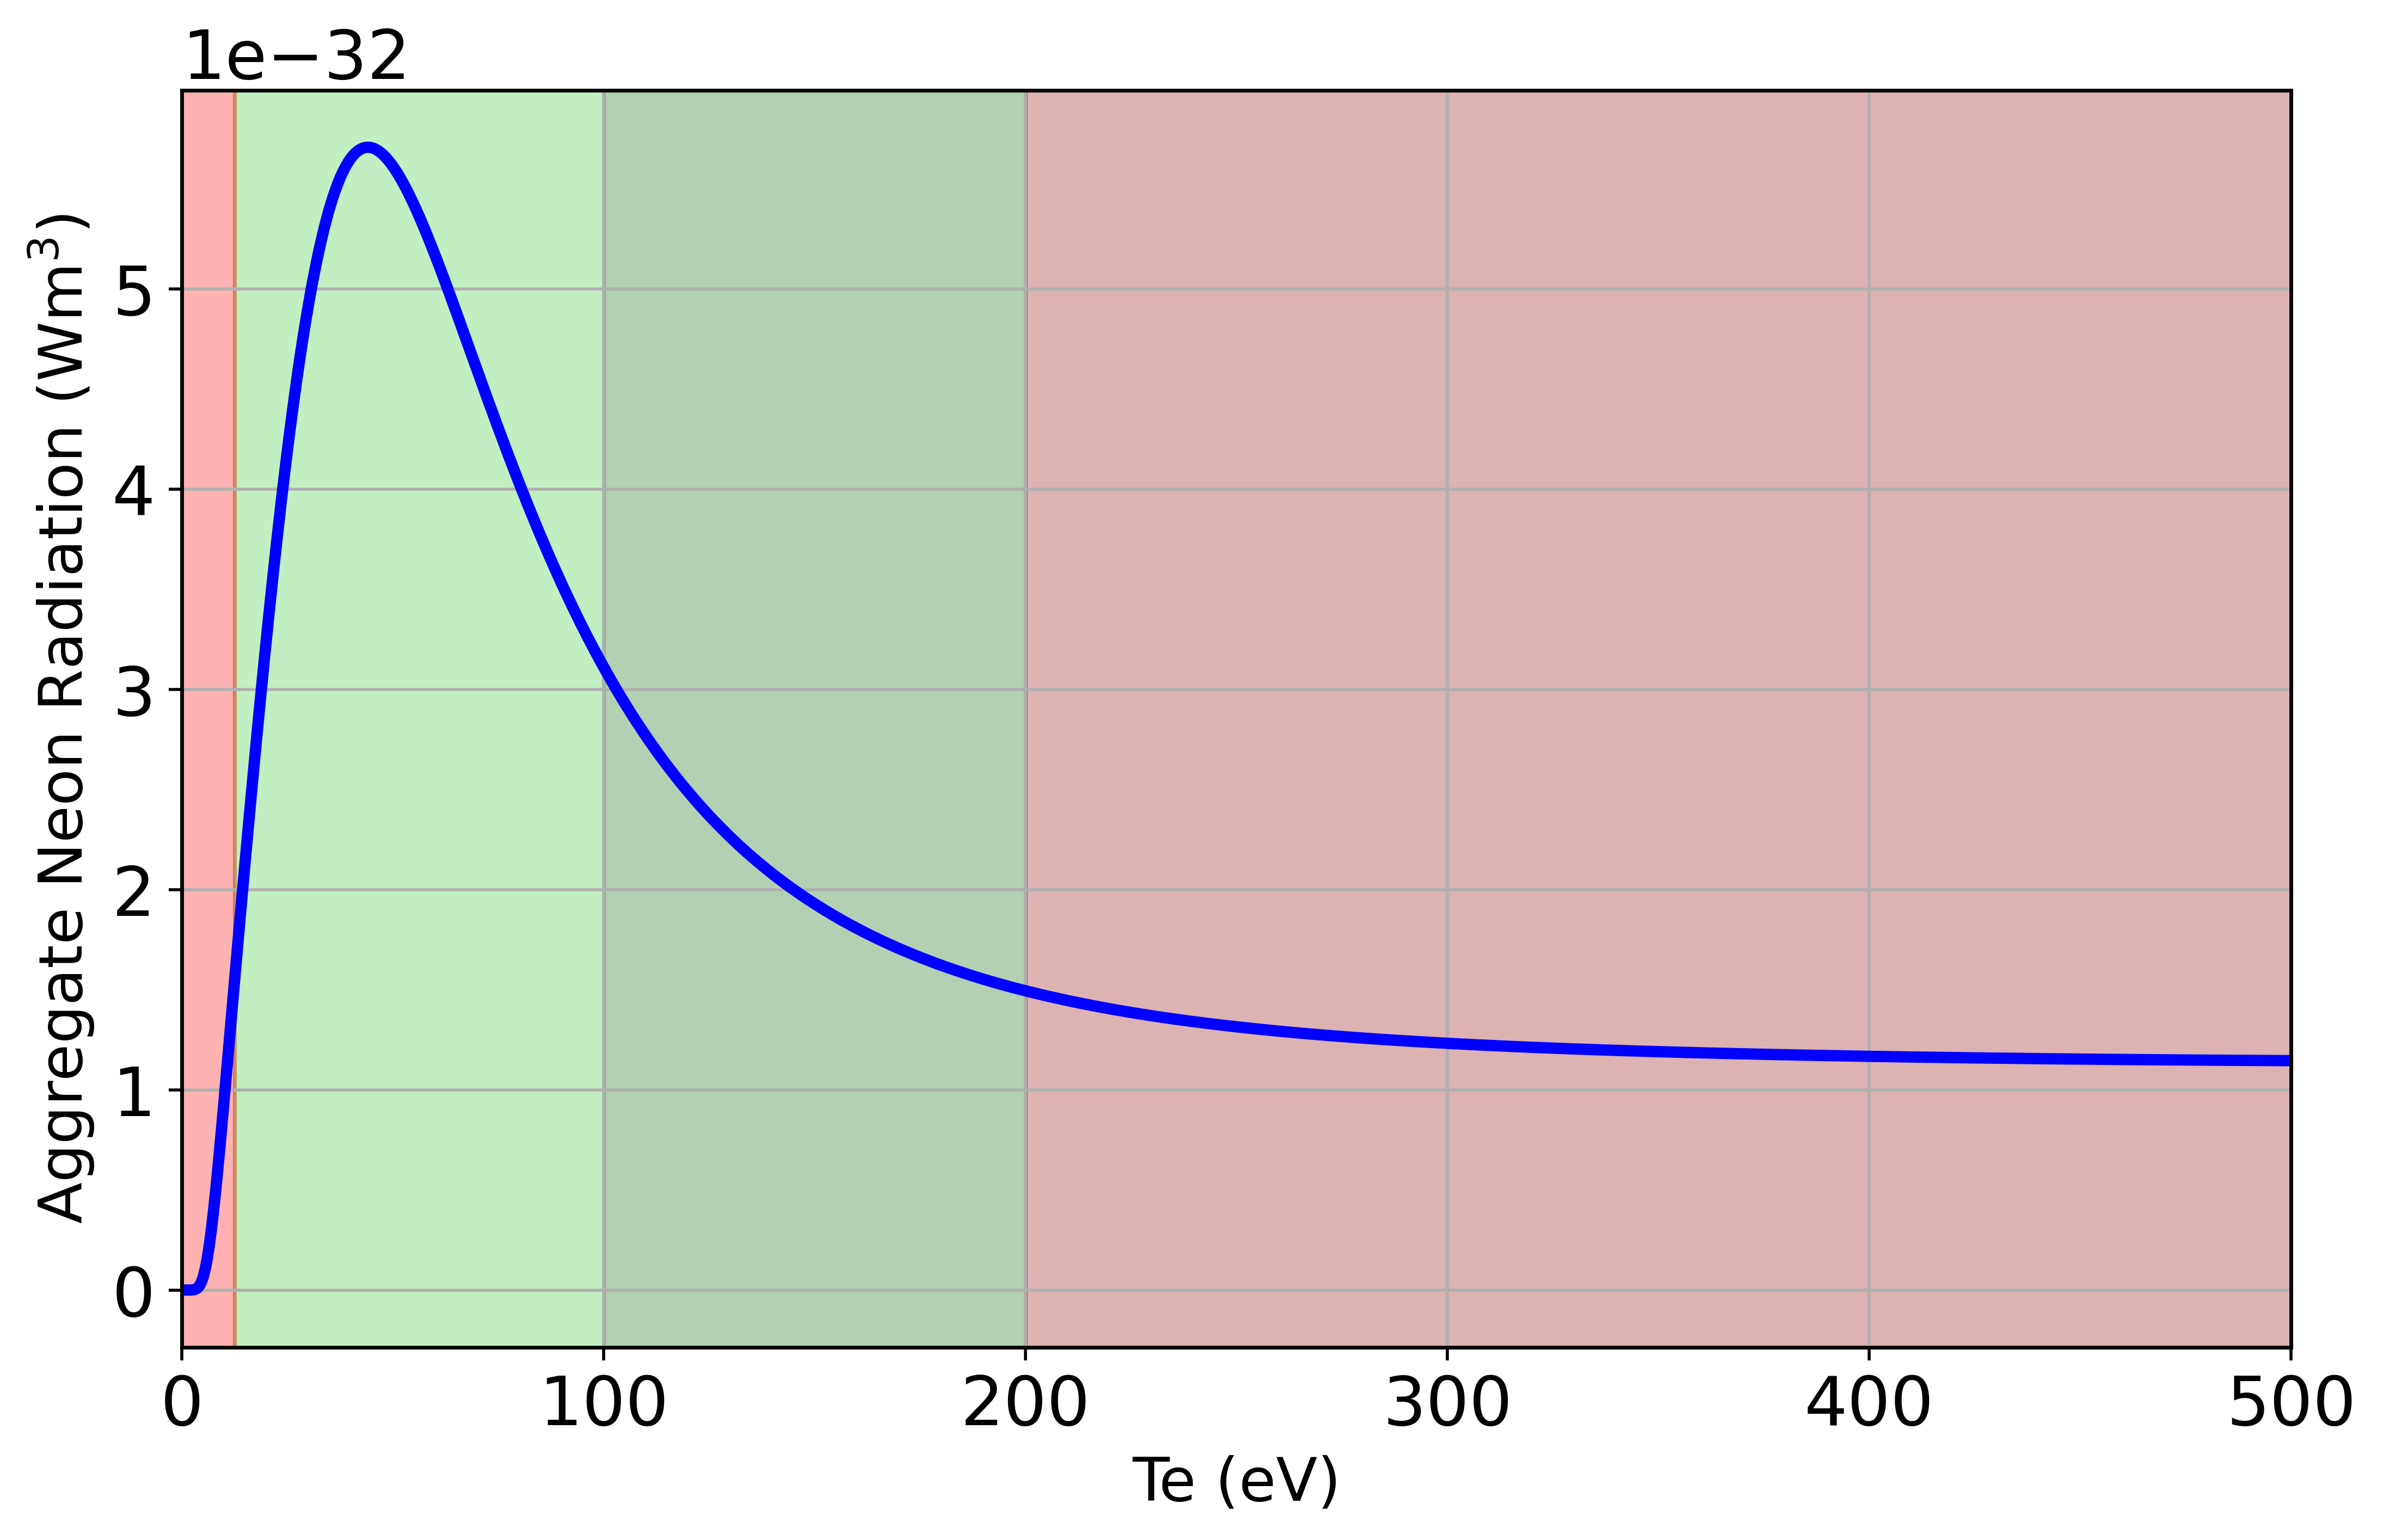

In [63]:
import numpy as np

def neon_adas_curve(Te):
    logT = np.log(Te)
    log_out = np.zeros_like(Te)

    # Coefficients for the polynomial part
    coefficients = np.array([
        -8.21475117e+01, 1.28929854e+01, -4.74266289e+01,
         7.45222324e+01, -5.75710722e+01, 2.57375965e+01,
        -7.12758563e+00, 1.24287546e+00, -1.32943407e-01,
         7.97368445e-03, -2.05487897e-04
    ])

    # Valid temperature range for the polynomial
    valid_mask = (Te >= 2) & (Te <= 1000)
    below_mask = Te < 2
    above_mask = Te > 1000

    # Apply the polynomial coefficients
    for i, coeff in enumerate(coefficients):
        log_out[valid_mask] += coeff * logT[valid_mask] ** i
    
    # Apply the exponential to the valid range
    log_out[valid_mask] = np.exp(log_out[valid_mask])
    
    # Assign the constant values outside the valid temperature range
    log_out[below_mask] = 6.35304113e-36
    log_out[above_mask] = 1.17894628e-32

    return log_out

# Example usage with an array of temperatures:
Te_array = np.array([1.0, 5.0, 10.0, 100.0, 500.0, 1500.0])
output_values = neon_adas_curve(Te_array)
# print(output_values)


# Use this updated Neon_adas class to create the color map and overlay it onto the plot

Te = np.linspace(0, 500, 1000)  # Example temperature value
result = neon_adas_curve(Te)

fig,axis = plt.subplots(1, 1, figsize=(10, 6), dpi = 500)
# axis2 = axis.twinx()


max_index = np.argmax(result)
print(max_index)

print(Te[max_index])

axis.plot(Te, result, label='Neon ADAS Curve', linewidth=linewidth, color = 'blue')
axis.axvspan(100, 200, color='darkgreen', alpha=0.3)  # Red color with transparency
axis.axvspan(12.5, 100, color='limegreen', alpha=0.3)  # Red color with transparency
axis.axvspan(200, 500, color='darkred', alpha=0.3)  # Red color with transparency
axis.axvspan(0, 12.5, color='red', alpha=0.3)  # Red color with transparency

# for i in alpha_vals:

#     if i == -1:
#         linestyle = '--'
#         color = 'red'
#     elif i == 0.2:
#         linestyle = '-'
#         color = 'blue'
#     elif i == 0.06:
#         linestyle = '-'
#         color = 'black'
#     elif i == 'snb':
#         linestyle = ':'
#         color = 'magenta'
#     axis2.plot(replace_guards(cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)['Te'].values), replace_guards(cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)['Ne'].values), label=f'alpha = {i}', linewidth=linewidth)
# axis2.set_ylabel(r'Electron density (m$^{-3}$)')
# axis2.legend(loc='upper right')
    
axis.set_xlabel('Te (eV)')
axis.set_ylabel(r'Aggregate Neon Radiation (Wm$^{3}$)')
axis.set_xbound(0, 500)
# axis.set_yscale('log')
# axis.set_xbound(0,200)

snb


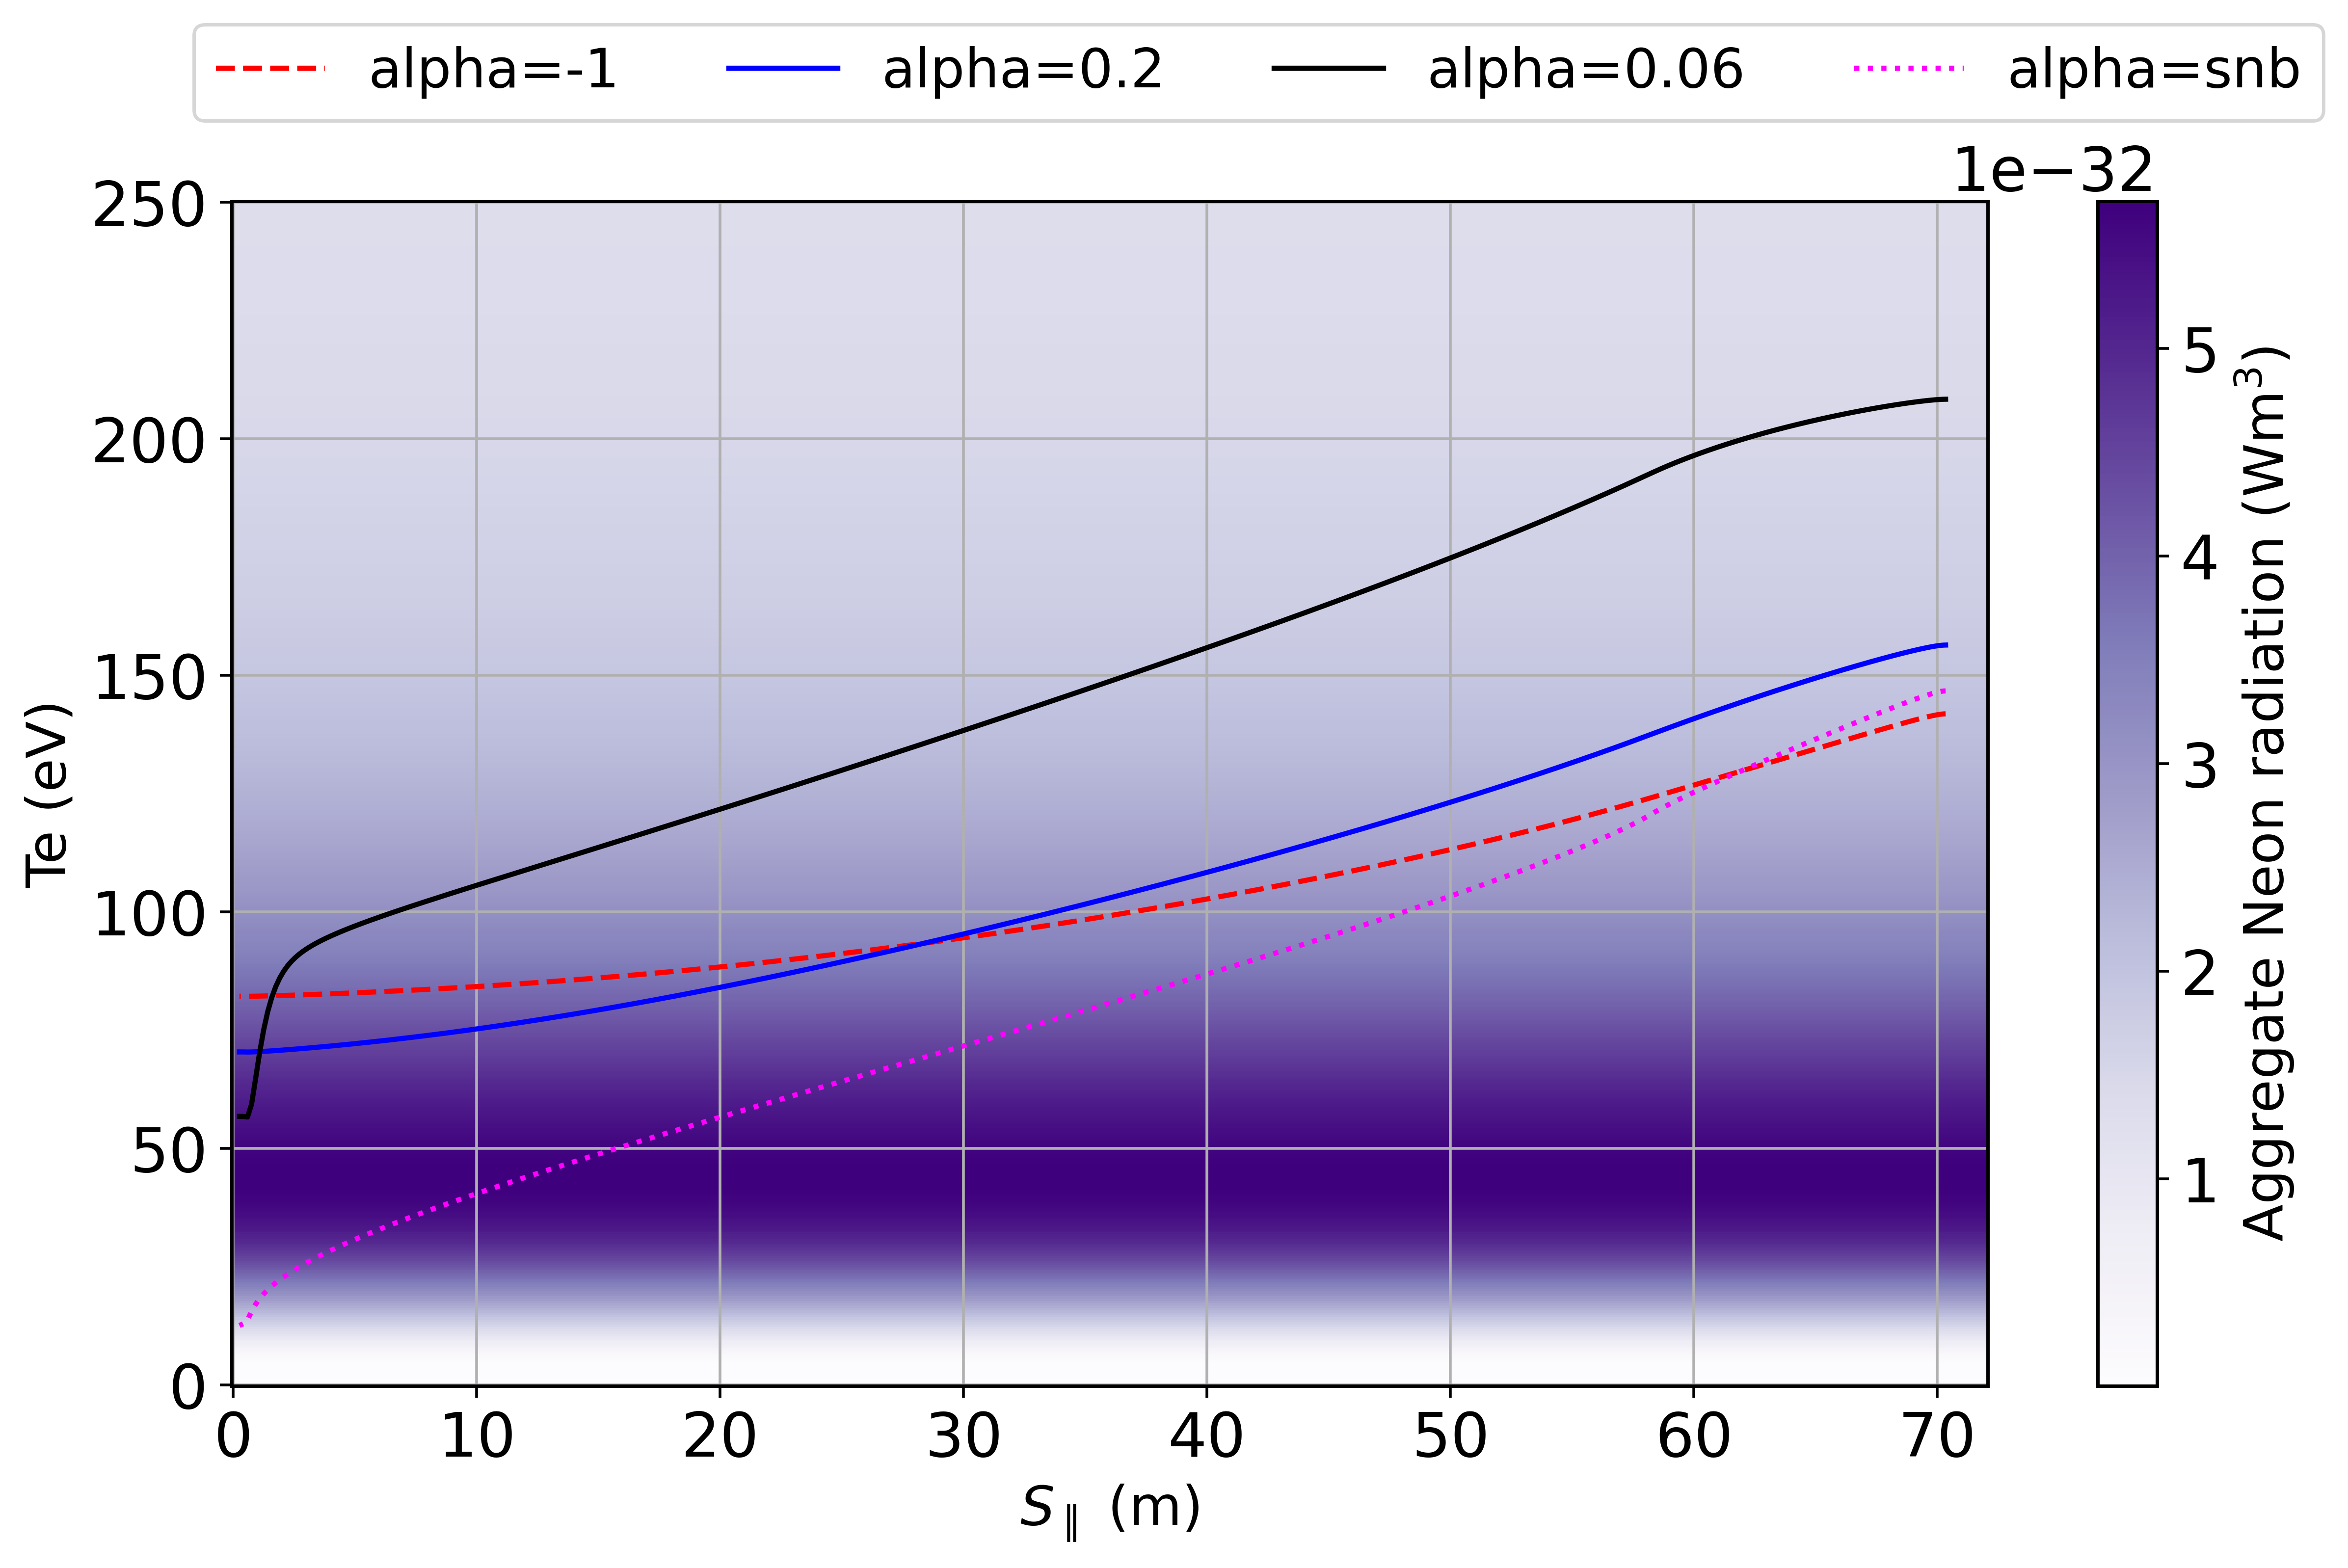

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Plot the colormap
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6), dpi = 500)
# ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left',bbox_to_anchor=(0.25, 0.2, 1, 1), bbox_transform=fig.transFigure)



S_II = np.linspace(0, 72, 500)  # Spatial coordinate
T_e = np.linspace(0, 250, 500)  # Electron temperature

# Create a meshgrid for S_II and T_e
S_II_grid, T_e_grid = np.meshgrid(S_II, T_e)

# Evaluate the curve function on the meshgrid
Z = neon_adas_curve(T_e_grid)

cmap = 'Purples'

norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
ax.pcolormesh(S_II_grid, T_e_grid, Z, shading='auto', norm=norm, cmap=cmap)
fig.colorbar(label=r'Aggregate Neon radiation (Wm$^{3}$)', mappable=ax.collections[0])


S_II = np.linspace(64, 72, 500)  # Spatial coordinate
T_e = np.linspace(0, 250, 500)  # Electron temperature



# Create a meshgrid for S_II and T_e
S_II_grid, T_e_grid = np.meshgrid(S_II, T_e)
Z = neon_adas_curve(T_e_grid)

norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
# colorbar.set_cmap('plasma')



y = cs['alpha_-1_neon_0.06'].ds['y'].values[1:-1]
for i in alpha_vals:
    if i == -1:
        linestyle = '--'
        color = 'red'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'
        print(i)

    profile = replace_guards(cs[f'alpha_{i}_neon_0.03'].ds.isel(t=-1)['Te'].values)
    ax.plot(y[::-1], profile, linestyle=linestyle, color=color, label=f'alpha={i}')
    # ax_inset.plot(y[-200:], profile[-200:], linestyle=linestyle, color=color, label=f'alpha={i}')


# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# # Desired order (SH, 0.2, 0.06)
# order = [0, 2, 1]

# # Reorder handles and labels
# handles = [handles[i] for i in order]
# labels = [labels[i] for i in order]

handles, labels = ax.get_legend_handles_labels()



# Create a single legend for the entire figure
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.04))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Make space for the legend

# Set labels and title as needed
ax.set_ylabel(r'Te (eV)')
ax.set_xlabel(r'$S_{\parallel}$ (m)')
# ax.set_xscale('log')
# ax.legend(handles, labels, loc = 'upper right')
plt.show()


In [65]:
low_tail = [0,12.5]
high_tail = [200,500]
peak = [12.5, 100]
slope = [100,200]


# Extract the temperature array
Te_values = cs['alpha_-1_neon_0.0'].ds.isel(t=-1)['Te'].values

# Define the temperature range
low, high = 12.5, 200

# Get the indices of elements within the range
indices = np.where((Te_values >= low) & (Te_values <= high))[0]

print("Indices of elements in range:", indices)


print(cs['alpha_-1_neon_0.0'].ds.isel(t=-1)['Rneon'])

print(np.sum(cs['alpha_-1_neon_0.0'].ds.isel(t=-1)['Rneon'].values * cs['alpha_-1_neon_0.0'].ds.isel(t=-1)['dv'].values))

Indices of elements in range: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 

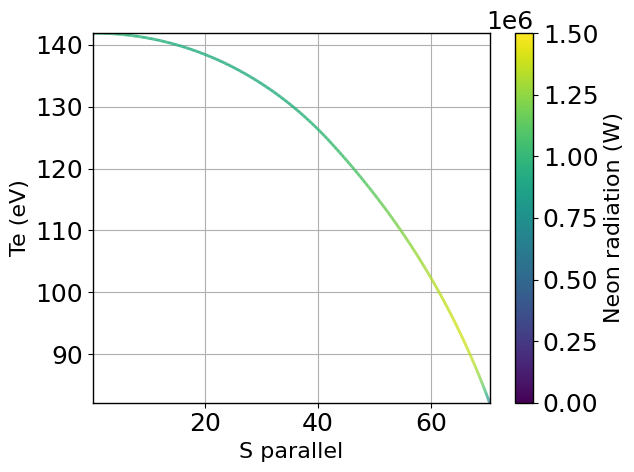

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

# Example data (Replace with actual data)
ds = cs['alpha_-1_neon_0.03'].ds.isel(t=-1)

vmin = 0
vmax = 1.5e6

x = ds['y'].values[1:-1]
y = ds['Te'].values[1:-1]  # primary profile
c = -1 * ds['Rneon'].values[1:-1] * ds['dv'].values[1:-1]  # colormap data

# Create line segments from x and y
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create LineCollection with explicit vmin/vmax
norm = plt.Normalize(vmin, vmax)
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(c)
lc.set_linewidth(2)
lc.set_clim(vmin, vmax)  # Correct way to set color limits

# Plot
fig, ax = plt.subplots()
line = ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())

# Add colorbar
cbar = plt.colorbar(line, ax=ax, label='Neon radiation (W)')

# Labels
plt.xlabel('S parallel')
plt.ylabel('Te (eV)')

plt.show()


# 7% neon four plot

2 2
x = 802
div_q_snb =  802


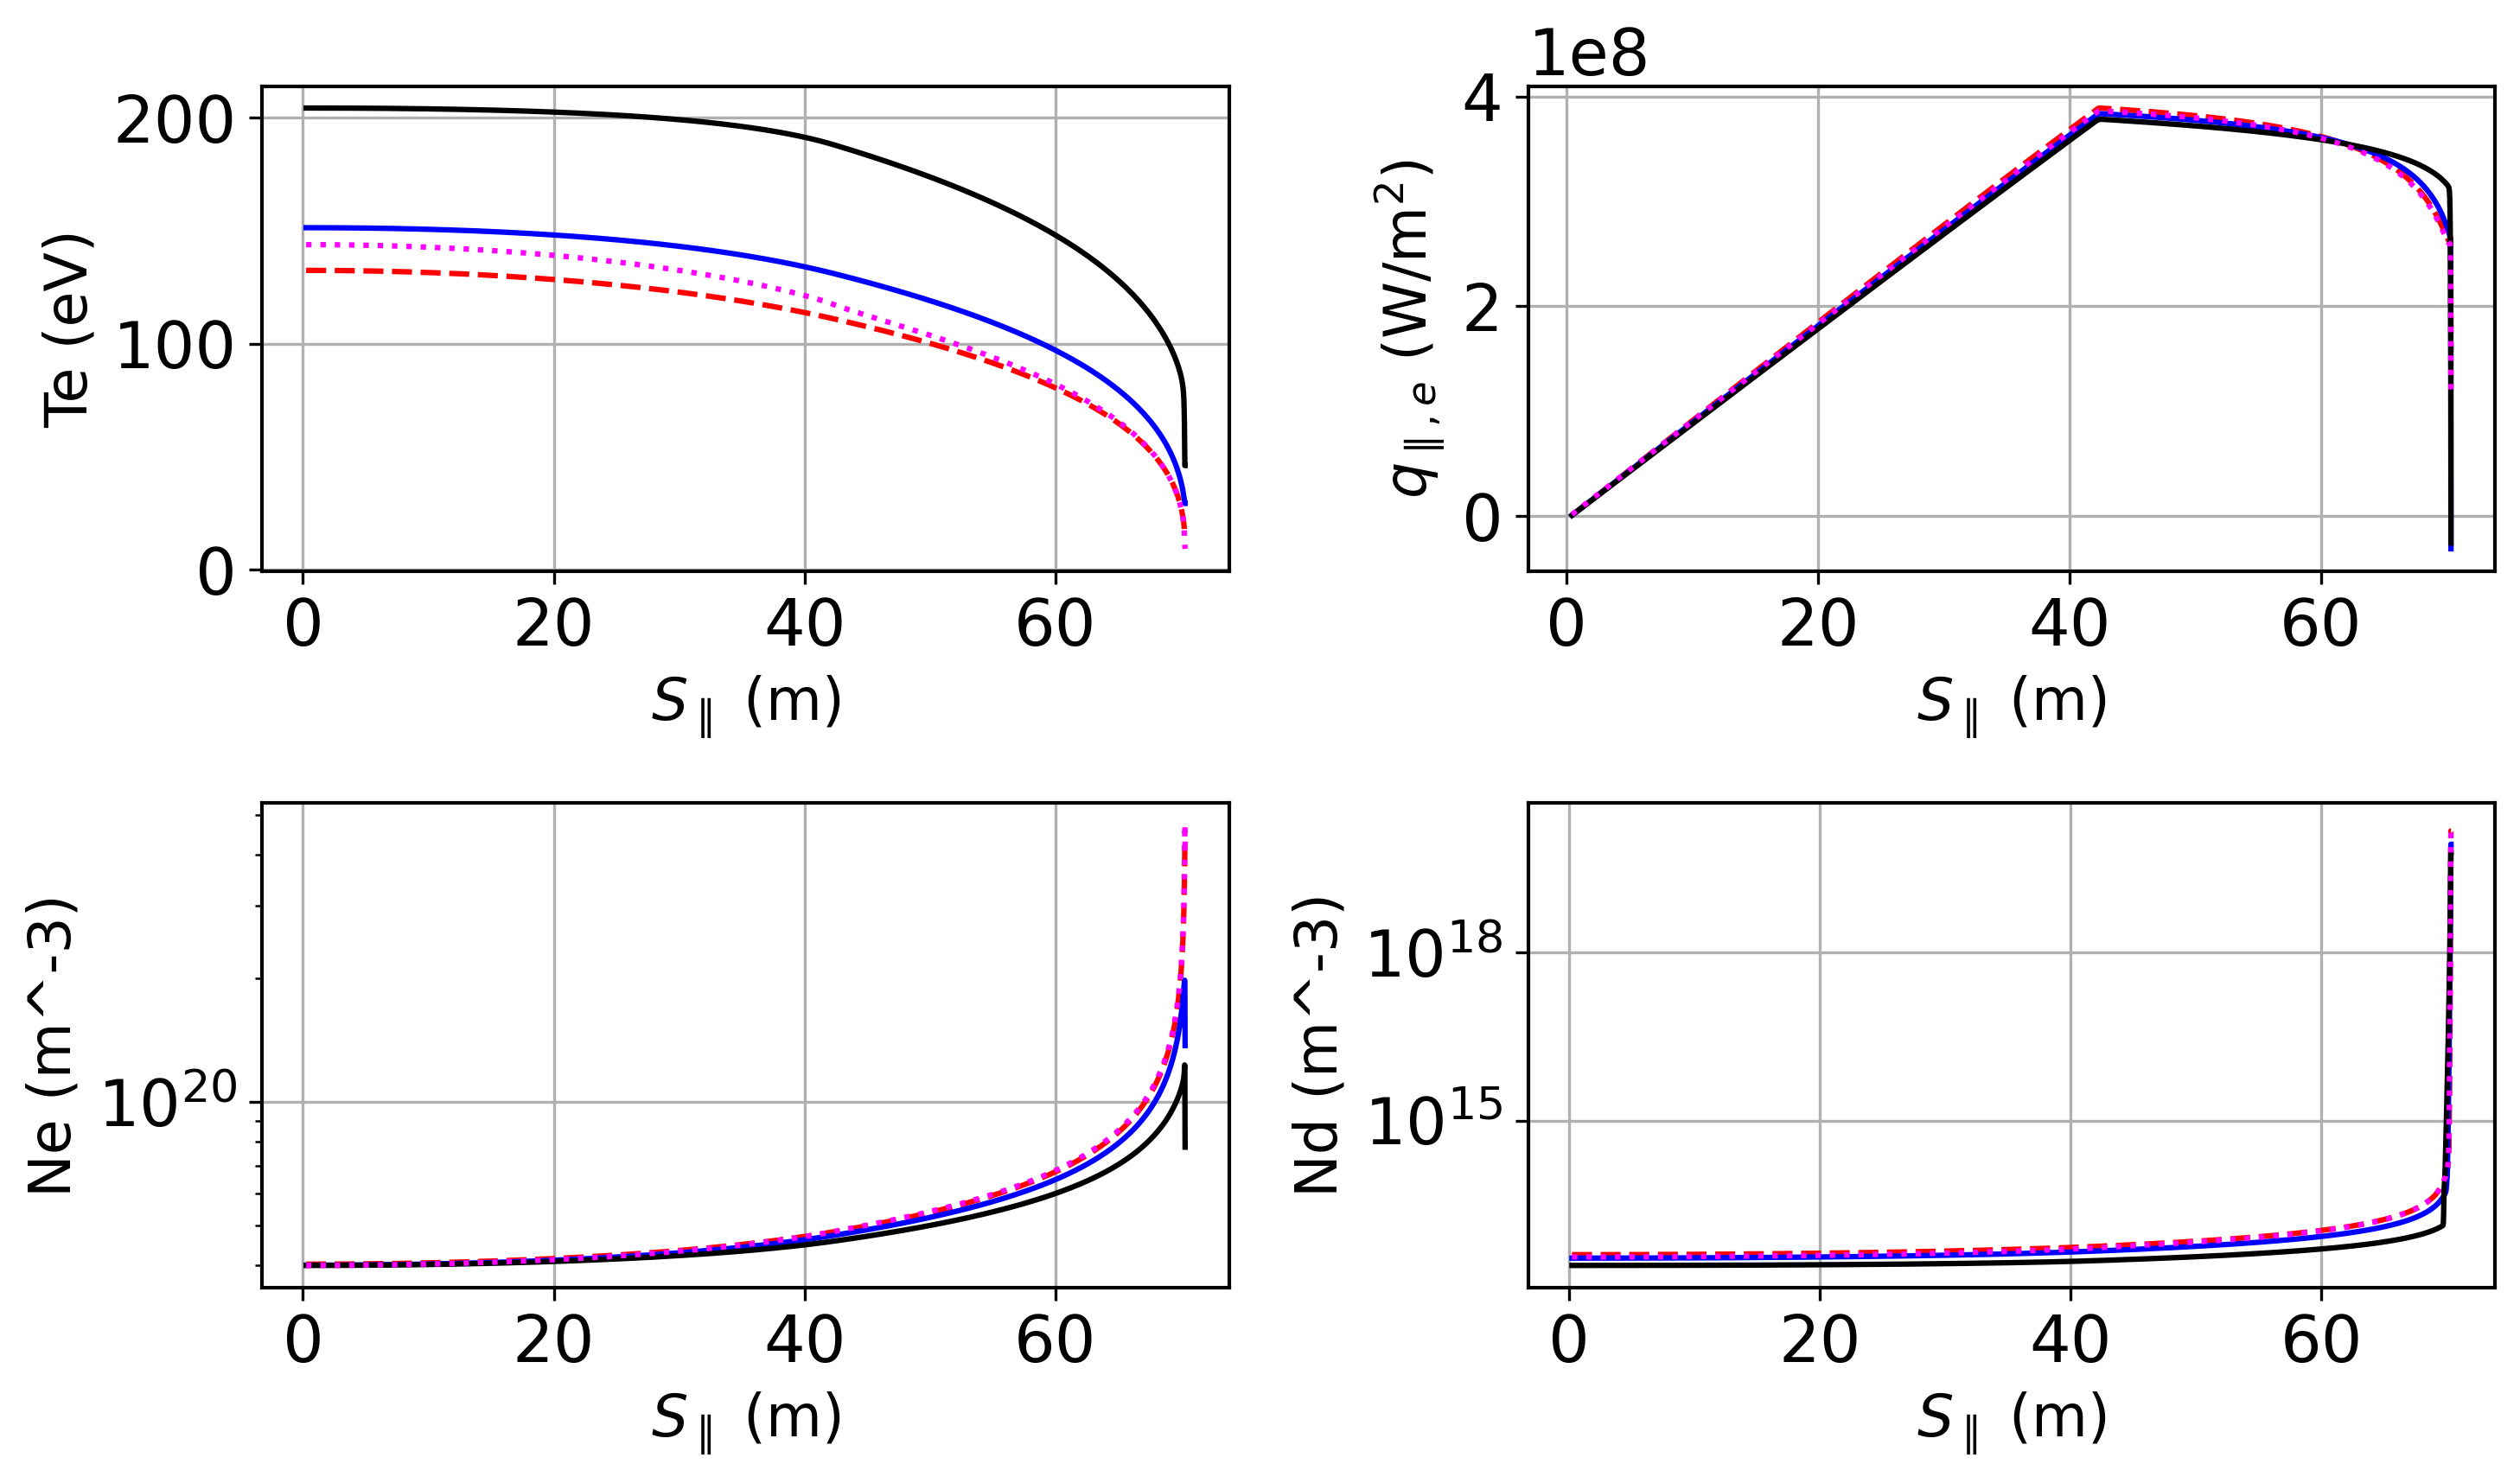

In [67]:
params = ['Te', 'q_cond', 'Ne', 'Nd']
neon_value = '0.04'
# params = ['Te']

ncols = max(round(len(params)/2), 1)
nrows = ncols

print(ncols, nrows)

fig, ax = plt.subplots(nrows, ncols, figsize=(10, 6), dpi=300)

if isinstance(ax, np.ndarray):  # When multiple subplots
    ax = ax.flatten()  # Flatten the 2D array of axes to 1D
else:  # When there is only one subplot
    ax = np.array([ax])  # Make it a 1D array for consistency

y = cs['alpha_-1_neon_0.0'].ds['y'].values[1:-1]
for i in alpha_vals:
    if i == -1:
        linestyle = '--'
        color = 'red'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'

    for j, value in enumerate(params):

        if value == 'q_cond':
            if i == 'snb':
                profile = divq_integrate(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1), snb_int=True)
            else:
                profile = replace_guards(spitzer_q(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)))

            ax[j].plot(y[1:-1], profile[1:-1], linestyle=linestyle, color=color, label=f'alpha={i}')
            if np.max(profile) > 1e3:
                # ax[j].set_yscale('log')
                ax[j].set_ylabel(r'$q_{\parallel, e}$ (W/m$^2$)')
                ax[j].set_xlabel('$S_{\parallel}$ (m)')

        else:
            profile = replace_guards(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)[value].values)
            ax[j].plot(y, profile, linestyle=linestyle, color=color, label=f'alpha={i}')
            if np.max(profile) > 1e3:
                ax[j].set_yscale('log')
            ax[j].set_xlabel('$S_{\parallel}$ (m)')
            units = cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].units
            ax[j].set_ylabel(f'{value} ({units})')

plt.tight_layout()

# for axes in ax:
#     axes.set_xscale('log')

2 2
x = 802
div_q_snb =  802


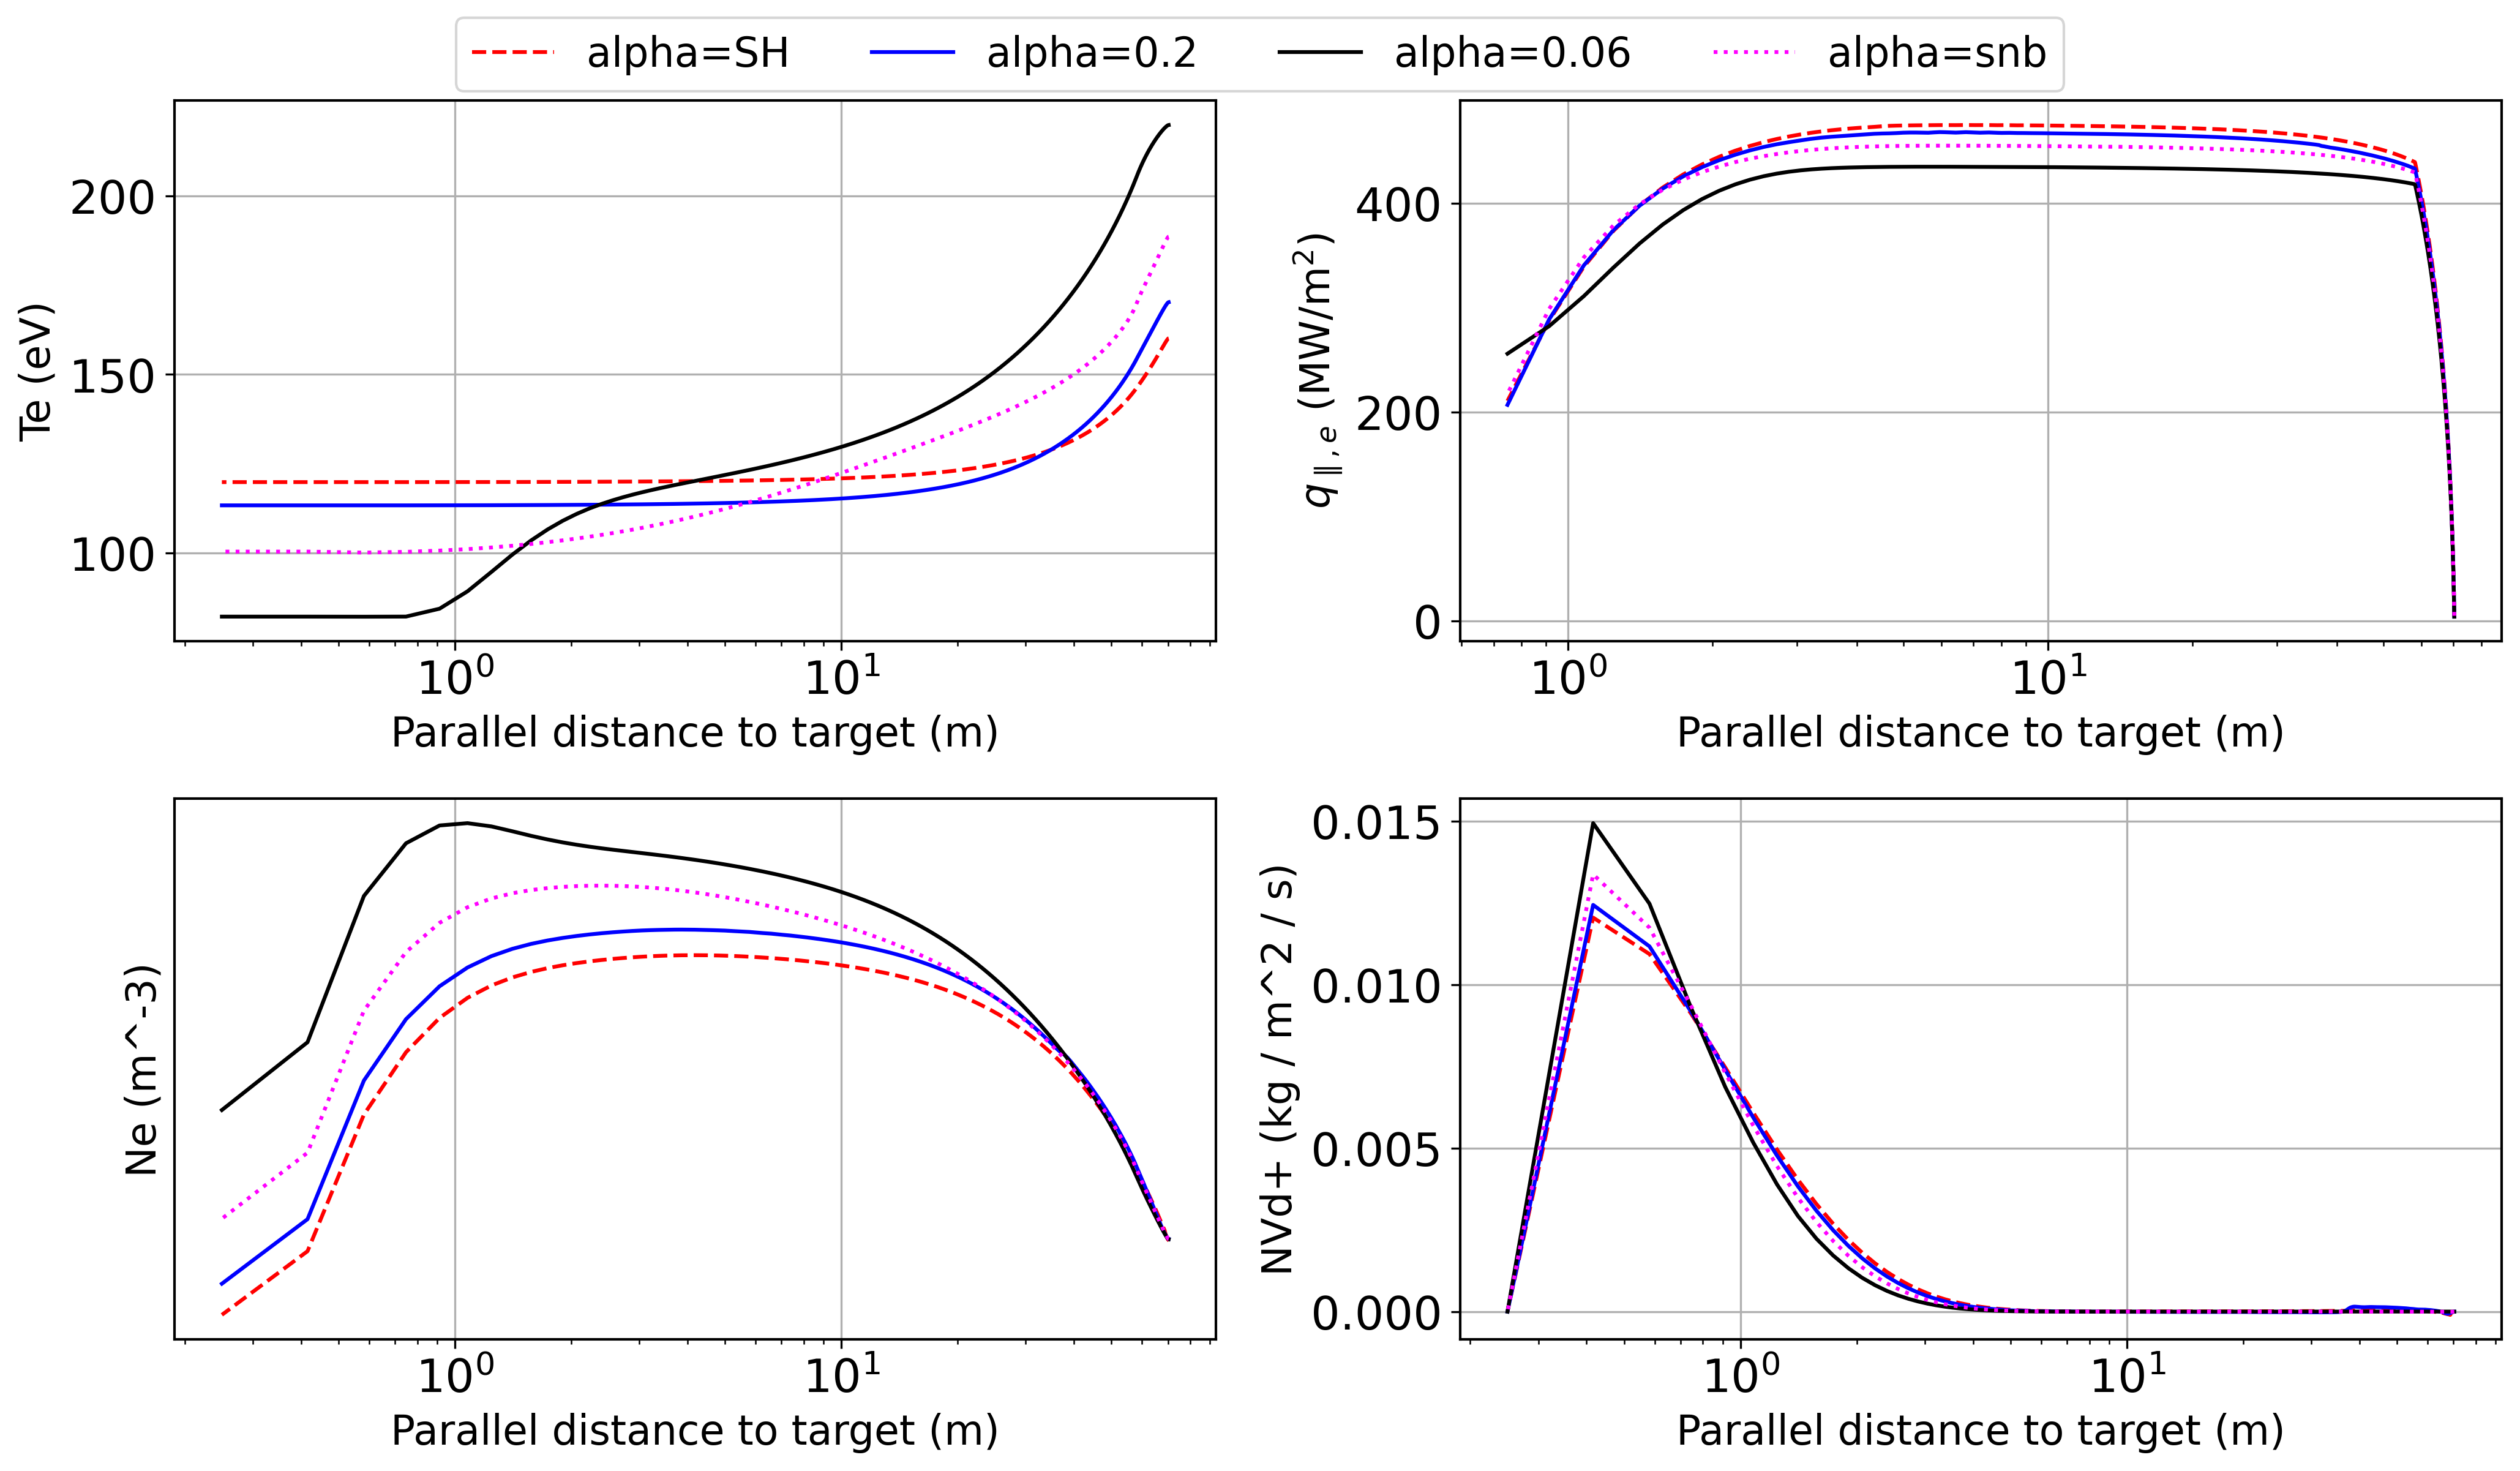

In [119]:
params = ['Te',  'q_cond', 'Ne', 'NVd+']
neon_value = '0.0'
# params = ['Te']

ncols = max(round(len(params)/2), 1)
nrows = ncols

print(ncols, nrows)

fig, ax = plt.subplots(nrows, ncols, figsize=(14, 8), dpi=300)

if isinstance(ax, np.ndarray):  # When multiple subplots
    ax = ax.flatten()  # Flatten the 2D array of axes to 1D
else:  # When there is only one subplot
    ax = np.array([ax])  # Make it a 1D array for consistency

y = cs['alpha_-1_neon_0.0'].ds['y'].values[1:-1]
for i in alpha_vals:
    label = i
    if i == -1:
        linestyle = '--'
        color = 'red'
        label = 'SH'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'

    for j, value in enumerate(params):

        if value == 'q_cond':
            if i == 'snb':
                profile = divq_integrate(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1), snb_int=True)
            else:
                profile = replace_guards(spitzer_q(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)))

            ax[j].plot(y[::-1][3:-3], profile[3:-3] * 1e-6, linestyle=linestyle, color=color, label=f'alpha={label}')
            if np.max(profile) > 1e3:
                # ax[j].set_yscale('log')
                ax[j].set_ylabel(r'$q_{\parallel, e}$ (MW/m$^2$)')
                ax[j].set_xlabel('$S_{\parallel}$ (m)')

        elif value == 'Rneon':
            profile = -1 * replace_guards(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)[value].values) * replace_guards(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)['dv'].values)
            ax[j].plot(y[::-1][1:-1], profile[1:-1], linestyle=linestyle, color=color, label=f'alpha={label}')
            # if np.max(profile) > 1e3:
            #     # ax[j].set_yscale('symlog')
            ax[j].set_xlabel('$S_{\parallel}$ (m)')
            units = cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].units
            ax[j].set_ylabel(f'Neon radiation (W)')

        # elif value == 'Vd+':
        #     profile = replace_guards(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)[value].values) * replace_guards(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)['Nd+'].values)
        #     ax[j].plot(y[::-1], profile, linestyle=linestyle, color=color, label=f'alpha={label}')
        #     # if np.max(profile) > 1e3:
        #         # ax[j].set_yscale('symlog')
        #     ax[j].set_xlabel('$S_{\parallel}$ (m)')
        #     units = cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].units
        #     ax[j].set_ylabel(f'Ion flux to target ({units})')

        else:
            profile = replace_guards(cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)[value].values)
            ax[j].plot(y[::-1], profile, linestyle=linestyle, color=color, label=f'alpha={label}')
            if np.max(profile) > 1e3:
                ax[j].set_yscale('symlog')
            ax[j].set_xlabel('$S_{\parallel}$ (m)')
            units = cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].units
            ax[j].set_ylabel(f'{value} ({units})')
plt.tight_layout()

for axes in ax:
    axes.set_xscale('log')
    axes.set_xlabel('Parallel distance to target (m)')
    # axes.invert_xaxis()

# Only get legend handles/labels from the first axis (assumes same labels on all)
handles, labels = ax[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Make space for the legend

x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802
x = 802
div_q_snb =  802


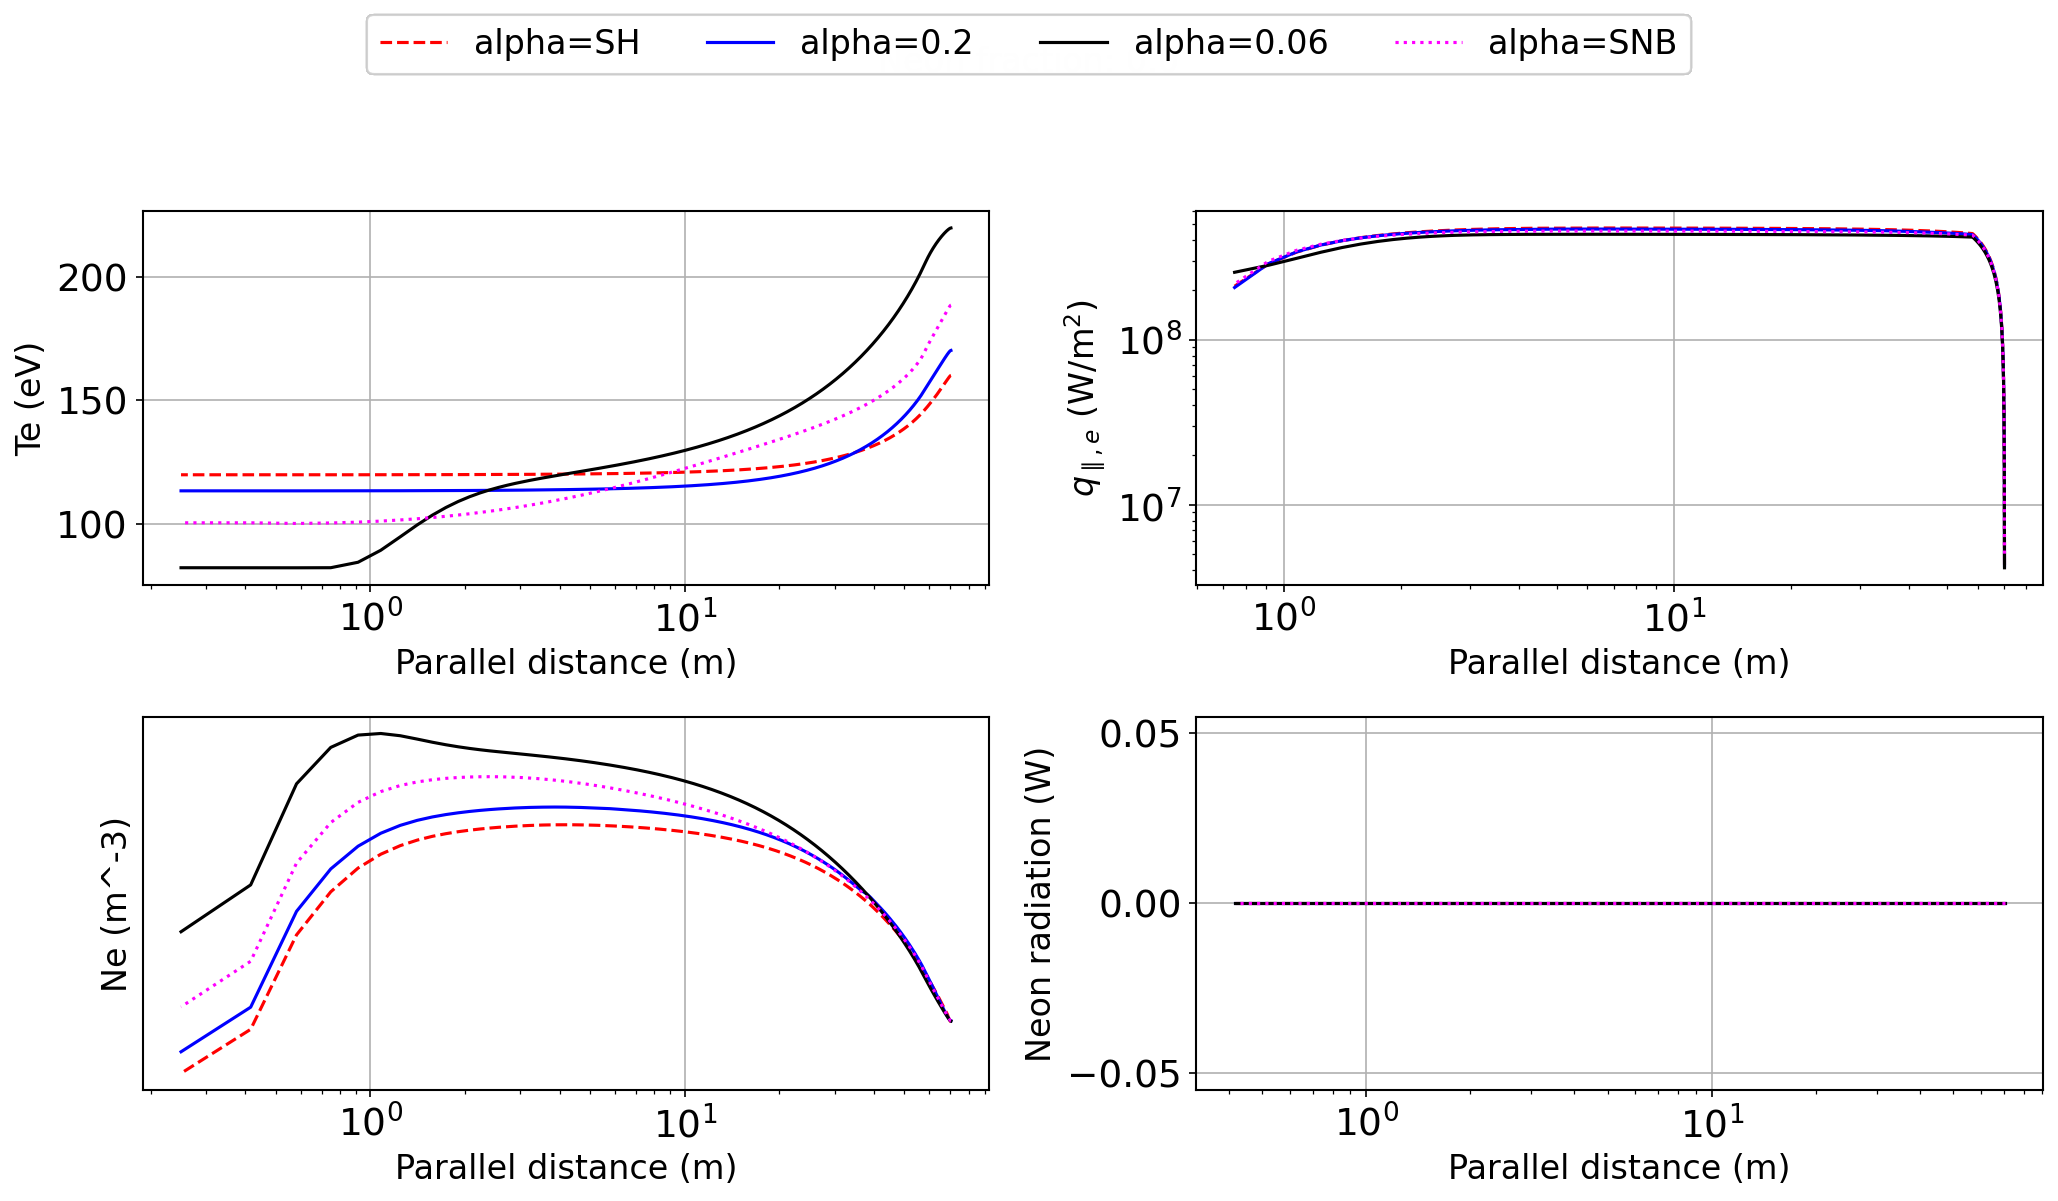

In [69]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# Your variables
params = ['Te', 'q_cond', 'Ne', 'Rneon']
neon_vals = ['0.0','0.01','0.02','0.03','0.04','0.05','0.06', '0.07','0.08','0.09', '0.1']
alpha_vals = [-1, 0.2, 0.06, 'snb']

ncols = max(round(len(params)/2), 1)
nrows = ncols

fig, ax = plt.subplots(nrows, ncols, figsize=(14, 8), dpi=150)
if isinstance(ax, np.ndarray):
    ax = ax.flatten()
else:
    ax = np.array([ax])

y = cs['alpha_-1_neon_0.0'].ds['y'].values[1:-1]

# Styling
style_map = {
    -1: {'linestyle': '--', 'color': 'red', 'label': 'SH'},
    0.2: {'linestyle': '-', 'color': 'blue', 'label': '0.2'},
    0.06: {'linestyle': '-', 'color': 'black', 'label': '0.06'},
    'snb': {'linestyle': ':', 'color': 'magenta', 'label': 'SNB'}
}

def update(frame):
    neon_value = neon_vals[frame]
    
    # Clear all axes for redraw
    for axes in ax:
        axes.clear()

    for i in alpha_vals:
        style = style_map[i]
        label = style['label']
        linestyle = style['linestyle']
        color = style['color']

        for j, value in enumerate(params):
            ds = cs[f'alpha_{i}_neon_{neon_value}'].ds.isel(t=-1)

            if value == 'q_cond':
                if i == 'snb':
                    profile = divq_integrate(ds, snb_int=True)
                else:
                    profile = replace_guards(spitzer_q(ds))
                # profile = divq_integrate(ds, snb_int=True) if i == 'snb' else replace_guards(spitzer_q(ds))
                x = y[::-1][3:-3]
                y_vals = profile[3:-3]
            elif value == 'Rneon':
                y_vals = -1 * replace_guards(ds['Rneon'].values) * replace_guards(ds['dv'].values)
                x = y[::-1][1:-1]
                y_vals = y_vals[1:-1]
            else:
                y_vals = replace_guards(ds[value].values)
                x = y[::-1]

            ax[j].plot(x, y_vals, linestyle=linestyle, color=color, label=f'alpha={label}')
            
            # Axes settings
            if value == 'q_cond':
                ax[j].set_ylabel(r'$q_{\parallel, e}$ (W/m$^2$)')
            elif value == 'Rneon':
                ax[j].set_ylabel('Neon radiation (W)')
            else:
                units = cs[f'alpha_{i}_neon_0.0'].ds.isel(t=-1)[value].units
                ax[j].set_ylabel(f'{value} ({units})')

            ax[j].set_xlabel('Parallel distance (m)')
            ax[j].set_xscale('log')
            if np.max(np.abs(y_vals)) > 1e3:
                ax[j].set_yscale('symlog' if value != 'q_cond' else 'log')

    # Title per frame
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f"Neon fraction: {neon_value}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])


    # Shared legend

# Animate
ani = FuncAnimation(fig, update, frames=len(neon_vals), repeat=False)

# Save as GIF
ani.save("multi_param_neon_sweep.gif", writer=PillowWriter(fps=1))


In [70]:
import imageio

# Read the GIF file
gif_reader = imageio.get_reader('multi_param_neon_sweep.gif')

# Write the MP4 file
with imageio.get_writer('multi_param_neon_sweep.mp4', fps=1) as writer:
    for frame in gif_reader:
        writer.append_data(frame)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2100, 1200) to (2112, 1200) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x6145580] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x6164ac0] Warning: data is not aligned! This can lead to a speed loss


[3611967.30185349 -292850.20828893 -292853.09504802 -292859.03298222]
[ 183889.47971307 -277970.94018814 -277972.19022793 -277973.73460756]
[  -8585.08267334 -227471.30904353 -227472.53708212 -227474.3593903 ]
[-211803.9561051  -257590.35078036 -257592.5960133  -257597.34342183]


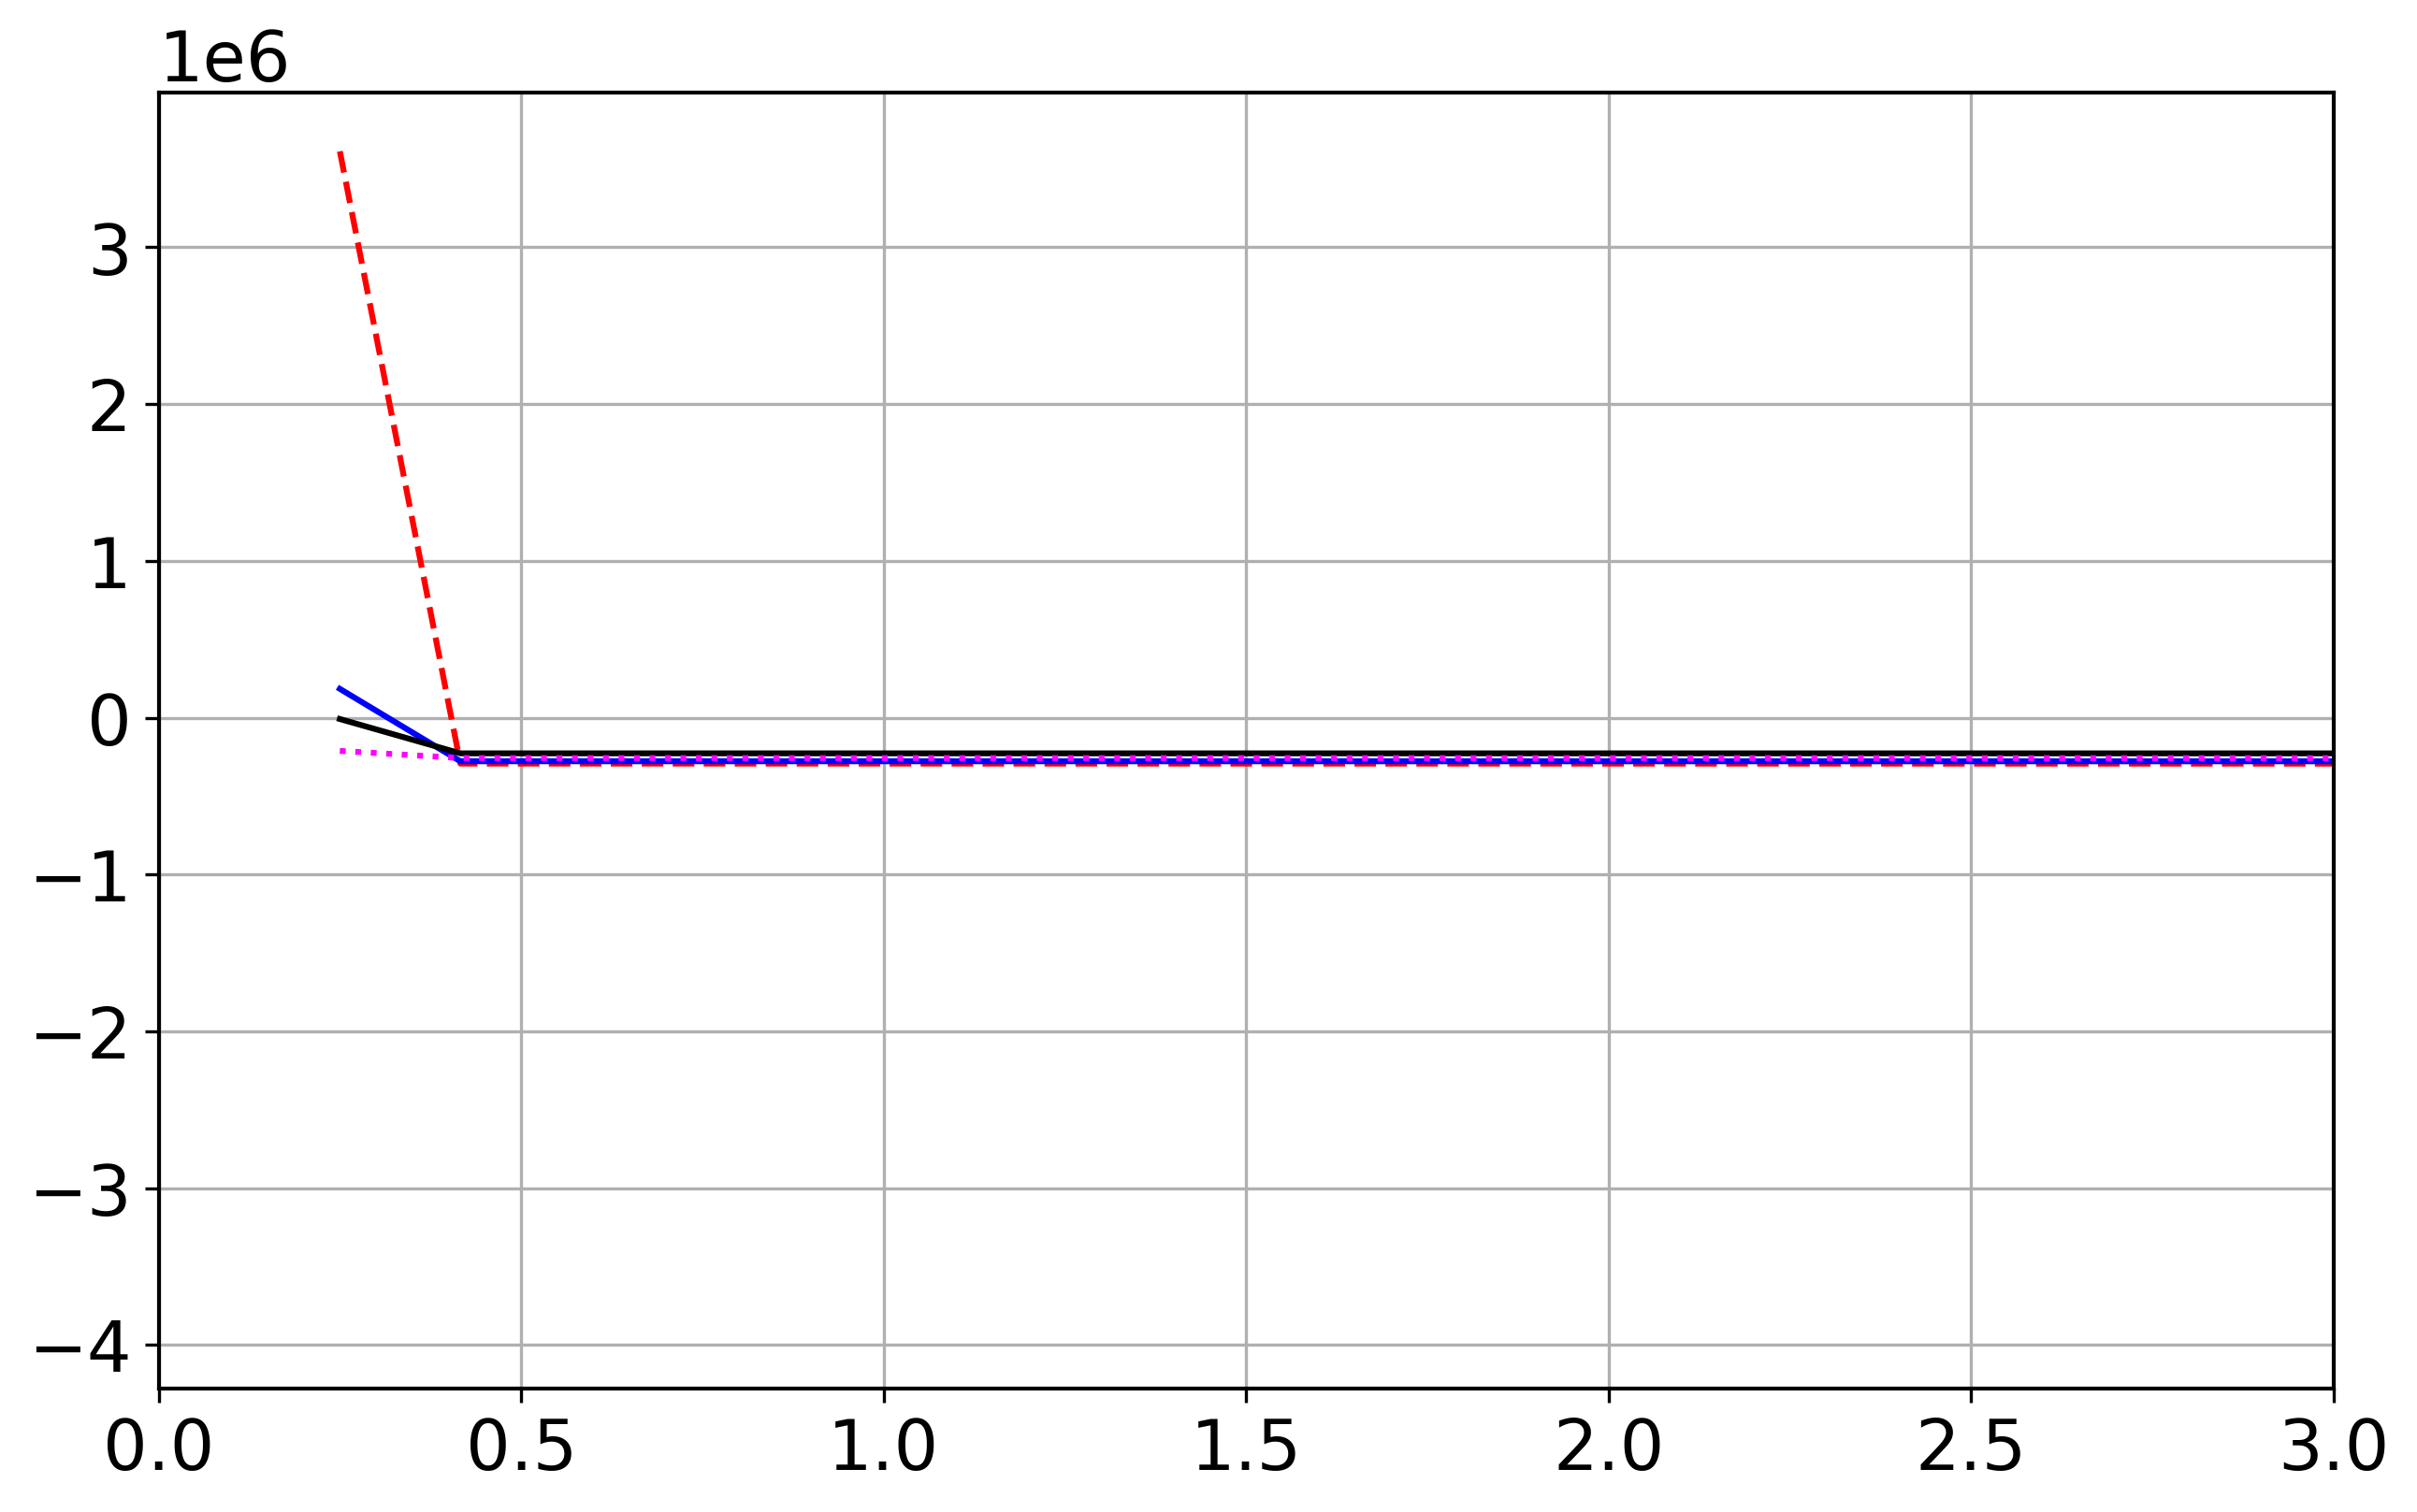

In [71]:
fig,ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

for i in alpha_vals:
    if i == -1:
        linestyle = '--'
        color = 'red'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'

    # for j in neon_vals:
    param = replace_guards(cs[f'alpha_{i}_neon_0.01'].ds.isel(t=-1)['Rneon'].values)
    ax.plot(y, param, linestyle=linestyle, color=color, label=f'alpha={i}')

    ax.set_xbound(0,3)
    print(param[:4])

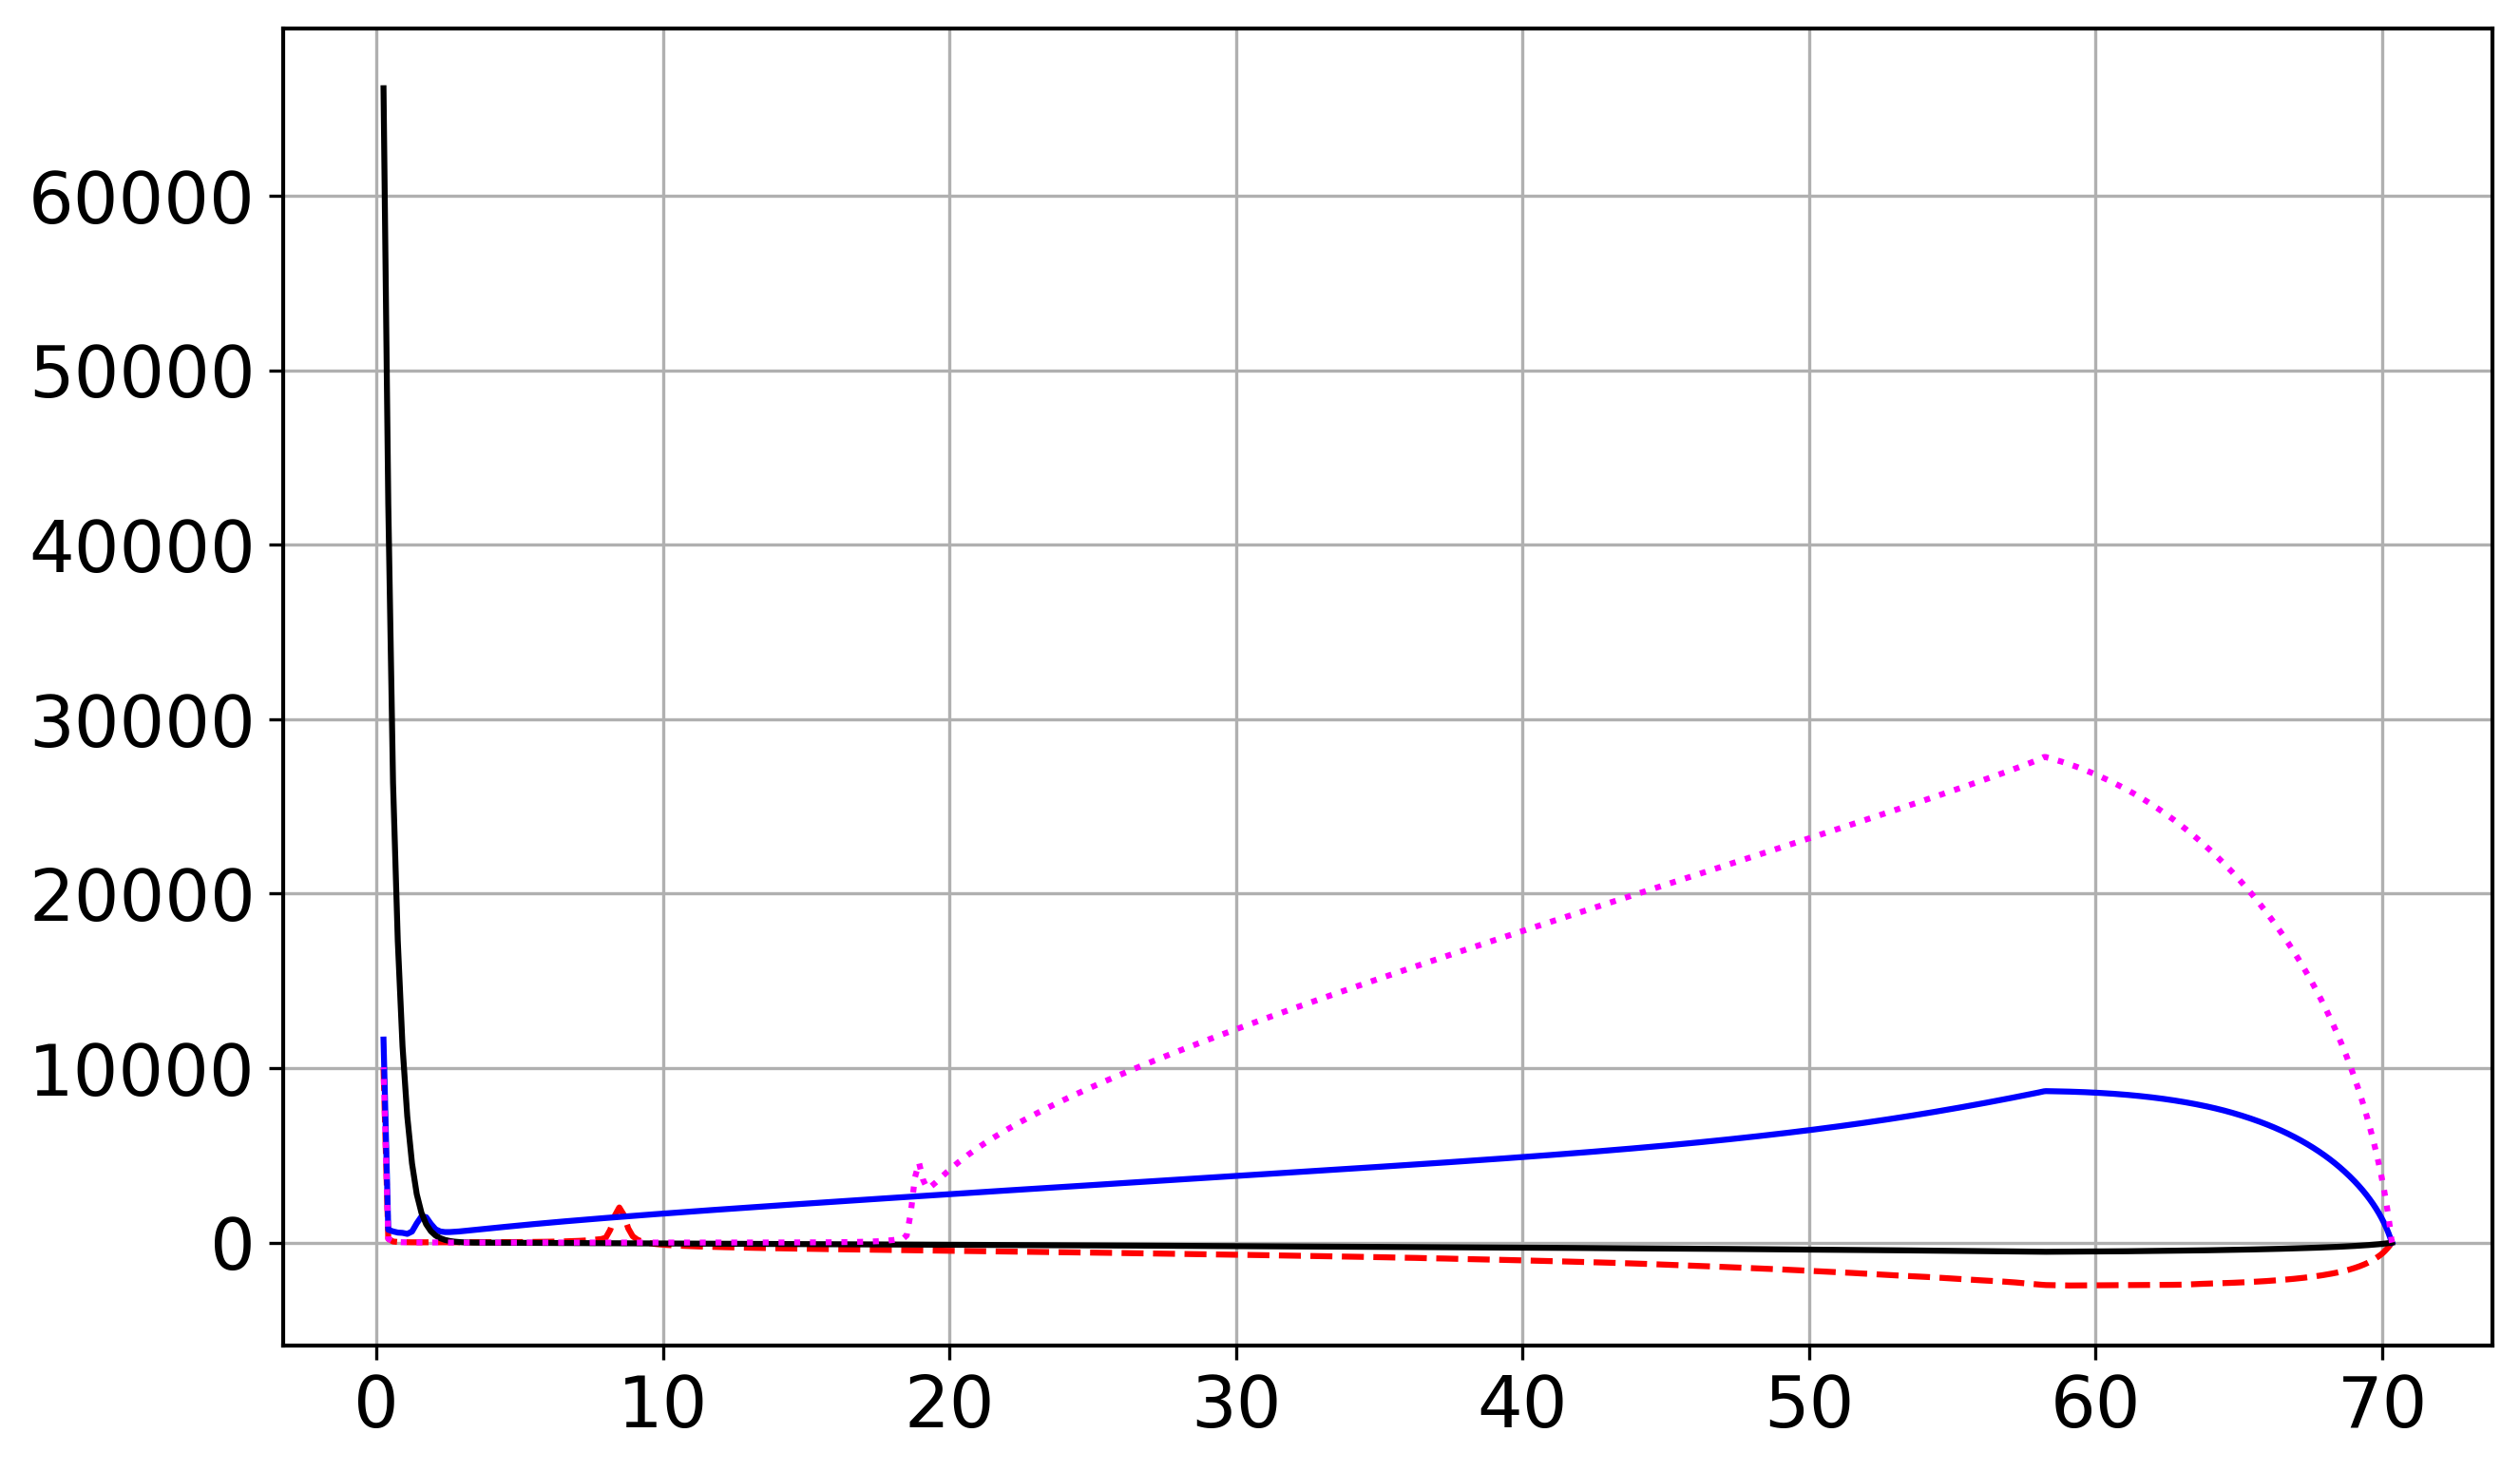

In [72]:
neon = 0.07

fig,ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
for i in alpha_vals:
    if i == -1:
        linestyle = '--'
        color = 'red'
    elif i == 0.2:
        linestyle = '-'
        color = 'blue'
    elif i == 0.06:
        linestyle = '-'
        color = 'black'
    elif i == 'snb':
        linestyle = ':'
        color = 'magenta'



    # for j in neon_vals:
    param = replace_guards(cs[f'alpha_{i}_neon_{neon}'].ds.isel(t=-1)['Vd+'].values) #* replace_guards(cs[f'alpha_{i}_neon_{neon}'].ds.isel(t=-1)['Vd+'].values)
    ax.plot(y[::-1], param, linestyle=linestyle, color=color, label=f'alpha={i}')
    # ax.p
    # ax.set_xscale('log')]
    # ax.set_yscale('log')